In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**University of Edinburgh**

**School of Mathematics**

**Bayesian Data Analysis, 2020/2021, Semester 2**

**Daniel Paulin & Nicolò Margaritella**

**Workshop 2: Introduction to JAGS**

**Note**: Before starting this practical, you might want to spend
some time looking at the JAGS examples we have discussed during Lecture 2. If
you already did it, then go directly to question 1.
The code below loads JAGS.

In [2]:
#This code loads a compiled version of JAGS and rjags from a zip file on Google Drive, and loads rjags. It should only take a few seconds.
#IMPORTANT: Go to the Kaggle Settings (right hand side) and enable the Internet option before running this.
system("wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1i7BlQ21kT4ZnYUjAxa8P-eCbe-Zfiz8j' -O /kaggle/working/kaggle_JAGS.zip")
system("unzip /kaggle/working/kaggle_JAGS.zip")
system("rm /kaggle/working/kaggle_JAGS.zip")
system("cd /kaggle/working/JAGS-4.3.0")
system("make install")
library(rjags,lib.loc="/kaggle/working")
#If it ran correctly, you should see 
#Loading required package: coda
#Linked to JAGS 4.3.0
#Loaded modules: basemod,bugs

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



**1.  Analysis of binomial data: revisiting the drug example**

**The aim of this question is to re-do most parts of questions 1 and 2
from the first practical but now using `JAGS`. Remember the context:
a new drug is being considered for relief of chronic pain, with the
success rate $\theta$ being the proportion of patients experiencing
pain relief. According to past information, a Beta(9.2, 13.8) prior
distribution was suggested. This drug had 15 successes out of 20
patients.**

**(i) Compute the posterior mean, standard deviation and a $95\%$
credible interval. Compare with the exact results.**

We will write a simple JAGS program that consists simply of the
binomial likelihood and the beta prior for the success rate
$\theta$.


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 1
   Total graph size: 5

Initializing model




Iterations = 2001:22000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.5624581      0.0745155      0.0005269      0.0006690 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.4150 0.5121 0.5632 0.6145 0.7055 


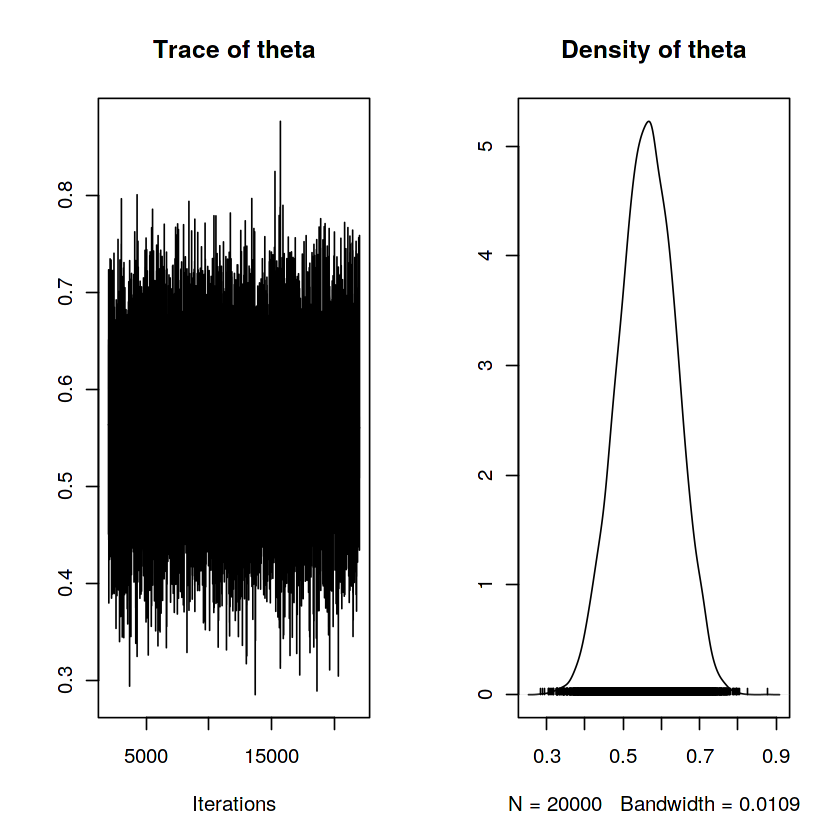

In [3]:
#Question 1 (i)
n=20; y=15; a=9.2; b=13.8

#model in BUGS syntax
model_string <- "model{
#likelihood
y~dbin(theta,n)

#prior
theta~dbeta(a, b)
}"

#compiling model
model=jags.model(textConnection(model_string),data = list(n=n,y=y,a=a,b=b),n.chains=1)

# Burnin for 1000 samples
update(model,1000,progress.bar="none")

# Running the model, monitoring the variable theta
res=coda.samples(model,variable.names=c("theta"), n.iter=20000,progress.bar="none")
summary(res); plot(res)

Traceplot and autocorrelation function do not indicate lack of
convergence. Results are similar to the ones obtained with exact
calculations.


**(ii) What is the probability that the true success rate is greater
than 0.6. Compare with the exact result.**

In [4]:
#Question 1 (ii)
cat("Pr(theta>0.6)=",mean(res[[1]]>0.6),"\n")

Pr(theta>0.6)= 0.3141 


**(iii) Suppose 40 more patients were entered into the study. What is
the chance that at least 25 of them experience pain relief?
Compare with the exact result.**

To compute the required posterior predictive probability in
JAGS we simply add the following two lines at the bottom of
the existing code

In [5]:
#Question 1 (iii)
n=20; y=15; a=9.2; b=13.8; n_new=40

#model in BUGS syntax
model_string <- "model{
#likelihood
y~dbin(theta,n)

#prior
theta~dbeta(a, b)

#predictive distribution
ypred~dbin(theta,n_new)
p25=step(ypred-25)     #equals 1 if ypred-25 >= 0, so an indicator
}"

We then repeat the process of compiling the model, running the
burn-in and sampling the values to be kept.

In [6]:

#compiling model
model=jags.model(textConnection(model_string),data = list(n=n,y=y,a=a,b=b,n_new=n_new),n.chains=1)

# Burnin for 1000 samples
update(model,1000,progress.bar="none")

# Running the model, monitoring the variable theta, ypred, and p25
res=coda.samples(model,variable.names=c("theta","ypred","p25"), n.iter=20000,progress.bar="none")
summary(res) 

#Alternatively, we do not need the variable p25, we can simply do mean(res[[1]][,"ypred"]>=25)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 2
   Total graph size: 10

Initializing model




Iterations = 2001:22000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
p25    0.3339 0.47162 0.0033348      0.0035871
theta  0.5635 0.07464 0.0005278      0.0006638
ypred 22.5881 4.27941 0.0302600      0.0343972

2. Quantiles for each variable:

         2.5%    25%     50%     75%  97.5%
p25    0.0000  0.000  0.0000  1.0000  1.000
theta  0.4146  0.512  0.5652  0.6155  0.705
ypred 14.0000 20.000 23.0000 26.0000 31.000


The quantity `p25` takes the value 1 when the predicted value
of $y$ is greater than 25 and 0 otherwise. Then, the chance of
observing at least 25 positive responses out of 40 new
patients is simply given by the proportion of 1s in the vector
`p25` (i.e., by its mean). From the information given above we
see that it is 0.33. Note that in fact the quantity `p25` is
not really needed, all we need is the quantity `ypred`, the
predicted number of positive responses out of the 40 new
patients. This quantity takes values between 0 and 40. From
the variable `ypred` we could count the proportion of values
that are equal or greater than 25.

In [7]:
cat("Pr(X>=25|n=40, data)=",mean(res[[1]][,"ypred"]>=25),"\n")

Pr(X>=25|n=40, data)= 0.3339 


In [8]:
mean(res[[1]][ ,"p25"])

[1] 0.3339

**(iv) Conduct the 'prior/data compatibility check', i.e., calculate
   the predictive probability of observing at least $15$ successes
   under this prior. Compare with the exact result.**

To compute the required probability, we simulate data under
this prior. The code is as follows:


In [9]:
#Question 1 (iv)
model_string <- "model{
theta ~ dbeta(a, b)
y~dbin(theta,n)
p15=step(y-15)
}"

model=jags.model(textConnection(model_string),data=list(n=n,a=a,b=b),n.chains=1)
update(model,1000,progress.bar="none")
res=coda.samples(model,variable.names=c("y","p15"),n.iter=20000,progress.bar="none")
summary(res)

#As above, we could also simply do mean(res[[1]][,"y"]>=15)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 0
   Unobserved stochastic nodes: 2
   Total graph size: 8

Initializing model




Iterations = 1001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean     SD  Naive SE Time-series SE
p15 0.01405 0.1177 0.0008323      0.0008323
y   8.01645 2.9274 0.0206996      0.0206996

2. Quantiles for each variable:

    2.5% 25% 50% 75% 97.5%
p15    0   0   0   0     0
y      3   6   8  10    14


Note that we are not passing to `jags.model` the data `y`.
Again, the quantity `p15` takes the value 1 when the generated
value $y$ is greater than 15 and 0 otherwise. Then, the
probability of observing at least 15 successes under this prior
is 0.0145. Note that as before, we do not really need `p15`;
all information that we need is contained in `y`. 

In [10]:
mean(res[[1]][,"y"]>=15)

[1] 0.01405

**(v) In practical 1 we have then considered a mixture prior, where it
was supposed that most drugs (95%) are assumed to come from the
stated Beta(9.2, 13.8) prior, but there is a small chance that
the drug might be a 'winner'. 'Winners' were assumed to have a
$\text{Beta}(12,3)$ prior distribution. What is now the chance
that the response rate is greater than 0.6? Compare with the
exact result.**

We first need to write in JAGS the model with the mixture prior,
which we do as follows.

In [11]:
#Question 1 (v) and (vi)
model_string <- "model{
y~dbinom(theta,n) 
theta~dbeta(a[pick], b[pick])         # a[1]=9.2, b[1]=13.8;  a[2]=12;  b[2] = 3 
pick~dcat(p[1:2])                     # pick takes value 1 or 2 with prior prob p[1] or p[2]
ypred~dbin(theta,n_new)                   
p25=step(ypred-25)                 
}"

# model_string <- "model{
# y~dbinom(theta,n) 
       
# theta1~dbeta(a[1], b[1]) 
# theta2~dbeta(a[2], b[2]) 
# pick~dbern(p[1]) # pick takes value 1 or 2 with prior prob p[1] or p[2]
# theta=pick*theta1+(1-pick)*theta2

# ypred~dbin(theta,n_new)                   
# p25=step(ypred-25)                 
# }"


Note that the main difference is that we now have a categorical
(in fact binary!) variable `pick` which takes the value 1 with
probability $p_1$ and value 2 with probability $p_2$. According
to the values of this variable, we will then select
$\theta\sim\text{Beta}(a_1,b_1)$ or
$\theta\sim\text{Beta}(a_2,b_2)$. The rest of the code is
similar to the ones we have been using.

In [12]:
n=20; y=15; a=c(9.2,12); b=c(13.8,3); p=c(0.95,0.05); n_new=40


model=jags.model(textConnection(model_string),data = 
                   list(y=y,n=n,n_new=n_new,a=a,b=b,p=p),n.chains=1)

# Burnin for 1000 samples
update(model,1000,progress.bar="none")

# Running the model
res=coda.samples(model, variable.names=c("theta","ypred","p25"), 
                 n.iter=20000,progress.bar="none")

# Question 2 (v)
#prob theta>0.6
cat("Pr(theta>0.6)=", mean(res[[1]][,"theta"] > 0.6),"\n") 

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 3
   Total graph size: 18

Initializing model

Pr(theta>0.6)= 0.58905 



Iterations = 2001:22000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean     SD  Naive SE Time-series SE
p25    0.5737 0.4946 0.0034970       0.008230
theta  0.6465 0.1248 0.0008822       0.002692
ypred 25.8030 5.8188 0.0411453       0.110008

2. Quantiles for each variable:

         2.5%     25%     50%     75%   97.5%
p25    0.0000  0.0000  1.0000  1.0000  1.0000
theta  0.4308  0.5488  0.6319  0.7529  0.8708
ypred 15.0000 22.0000 26.0000 30.0000 36.0000


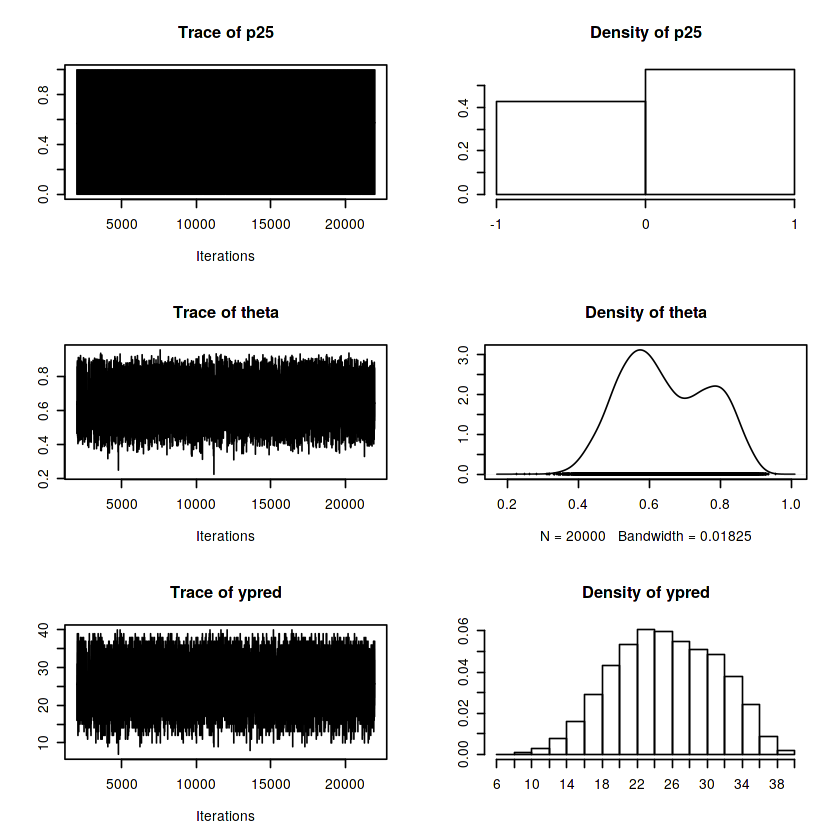

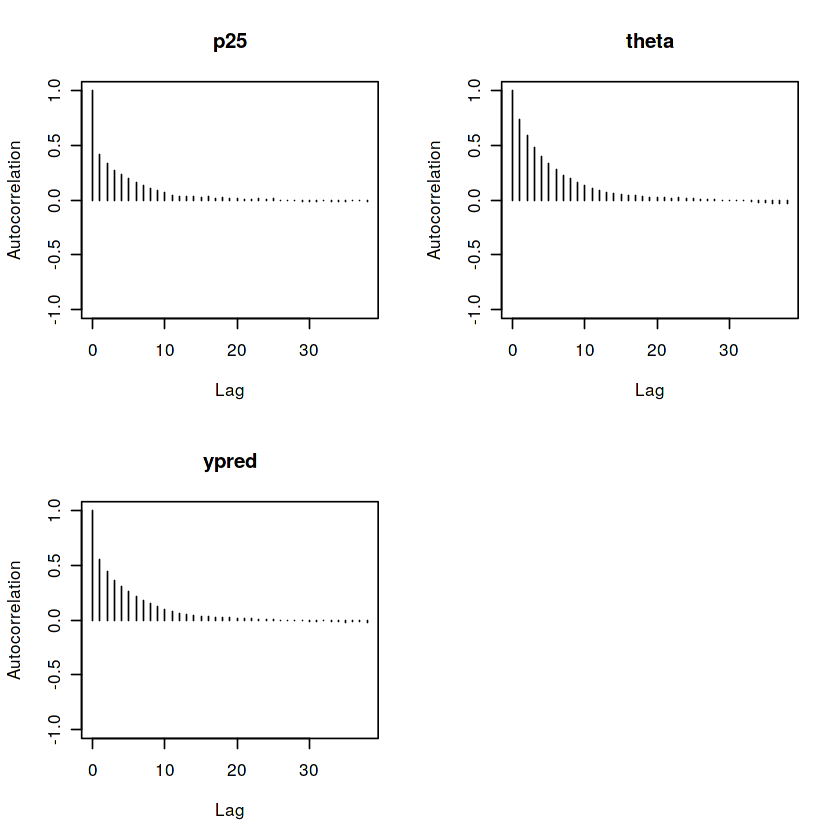

In [13]:
#Additional info about the results
summary(res)
plot(res)
autocorr.plot(res)

**(vi) Under this mixture prior, what is the posterior predictive
probability that at least 25 out of 40 new patients experience
pain relief?**

This can be computed from the MCMC samples easily, by taking the mean of the p25 indicator variable that we have created in JAGS.

In [14]:
# Question 2 (vi): Pr(X>=25|n=40, data)
# Using res from the code above for Question 2 part (v)
cat("Pr(X>=25|n=40, data)=",mean(res[[1]][,"p25"]),"\n")
# or mean(res[[1]][,"ypred"]>=25)

Pr(X>=25|n=40, data)= 0.5737 


**(vii) For this mixture prior, repeat the prior/data compatibility
    test performed previously. Are the data more compatible with
    this mixture prior? Compare with the exact result.**

This is similar to point (iv) but now using the mixture prior below.

In [15]:
#Question 1 (vii)

n <- 20; y <- 15
model_string <- "model{
y~dbinom(theta,n) 
theta~dbeta(a[pick], b[pick]) 
#theta is selected from a beta distribution with parameters chosen according to pick from
#parameter vectors a and b
#This corresponds to a mixture distribution
pick~dcat(p[1:2])                    
#pick is a categorical variable that is 1 with probability p[1] and 2 with probability p[2]
#This easily generalizes to higher dimensions
p15=step(y-15)
}"


model=jags.model(textConnection(model_string),data = list(n=n,a=a,b=b,p=p),n.chains=1)

update(model,1000,progress.bar="none")
res=coda.samples(model,variable.names=c("y","p15"),n.iter=20000,progress.bar="none")
summary(res)
#or mean(res[[1]][,"y"]>=15)


# Alternatively, you could write

# model_string <- "model{
# y~dbin(theta,n) 
# theta1~dbeta(a1, b1)       
# theta2~dbeta(a2, b2)
# theta=(1-component)*theta1+component*theta2
# component~dbern(p2)

# p15=step(y-15)
# }"

#model=jags.model(textConnection(model_string),
#       data = list(n=n,a1=9.2,b1=13.8,a2=12,b2=3,p2=0.05),n.chains=1)
#update(model,1000,progress.bar="none")
#res=coda.samples(model,variable.names=c("y","p15"),n.iter=20000,progress.bar="none")
#summary(res)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 0
   Unobserved stochastic nodes: 3
   Total graph size: 16

Initializing model




Iterations = 1001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean     SD Naive SE Time-series SE
p15 0.04885 0.2156 0.001524       0.001524
y   8.38285 3.3761 0.023872       0.023872

2. Quantiles for each variable:

    2.5% 25% 50% 75% 97.5%
p15    0   0   0   0     1
y      3   6   8  10    16


The asked probability is then 0.051.

2.  **Simple linear regression with robustification**

**Winning Olympic Men's Long Jump Distances (adapted from
 Witmer, 2017)**
 
**The data are the winning men's long jump distances (m) from 1900
through 2008. You will fit a linear regression of the distances as a
function of Olympic year: 
$$\begin{aligned}
Jump & = & \beta_0 + \beta_1 \mbox{Year} + \epsilon\end{aligned}$$
three different ways: standard frequentist approach, a Bayesian
approach assuming normal errors, and a Bayesian approach assuming a
$t$ distribution for errors.**

**Run the following commands in `R` to begin (this will install and load the package Stat2Data and load the Long Jump dataset).**

In [16]:
install.packages("Stat2Data", lib="/kaggle/working")
library(Stat2Data,lib.loc="/kaggle/working")
data("LongJumpOlympics")   #Makes the dataset available in this R session
Jump <- LongJumpOlympics$Gold
Year <- LongJumpOlympics$Year
#You can get more info about the dataset by the command
#help(topic="LongJumpOlympics",package="Stat2Data")

**1.  Carry out some exploratory data analysis:**

**1.1.  Plot Jump vs Year. What does the relationship look like?**

The plot is shown below. The relationship looks reasonably linear.

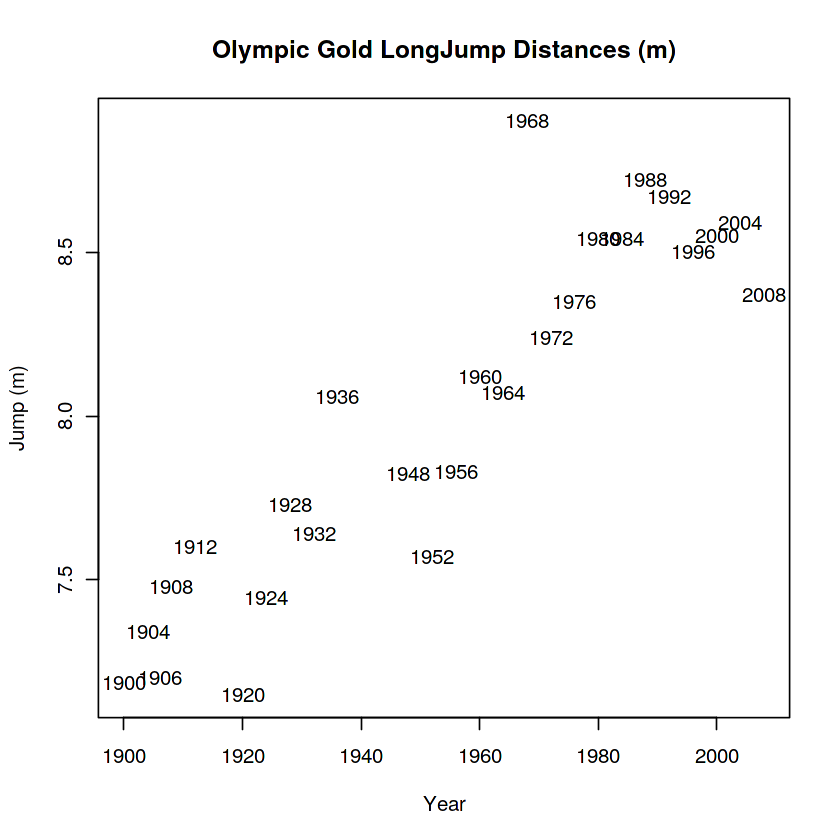

In [17]:
#1.1. Plot Jump vs Year 
par(mfrow=c(1,1))
plot(Jump ~ Year,xlab="Year",ylab="Jump (m)",
     type="n",main="Olympic Gold LongJump Distances (m)",cex=0.6)
text(x=Year,y=Jump,labels=Year)

**1.2.  Fit a simple linear regression on Jump against Year using the `lm` function,
and make a plot of the data with the fitted line overlaid using the `abline` function.**

See the `R` code below fitting the linear model. The figue shows the data with the best fit line
overlaid.



Call:
lm(formula = Jump ~ Year)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40256 -0.10991 -0.03256  0.12408  0.70239 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -19.483595   2.689700  -7.244 1.75e-07 ***
Year          0.014066   0.001376  10.223 3.19e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2375 on 24 degrees of freedom
Multiple R-squared:  0.8132,	Adjusted R-squared:  0.8055 
F-statistic: 104.5 on 1 and 24 DF,  p-value: 3.192e-10


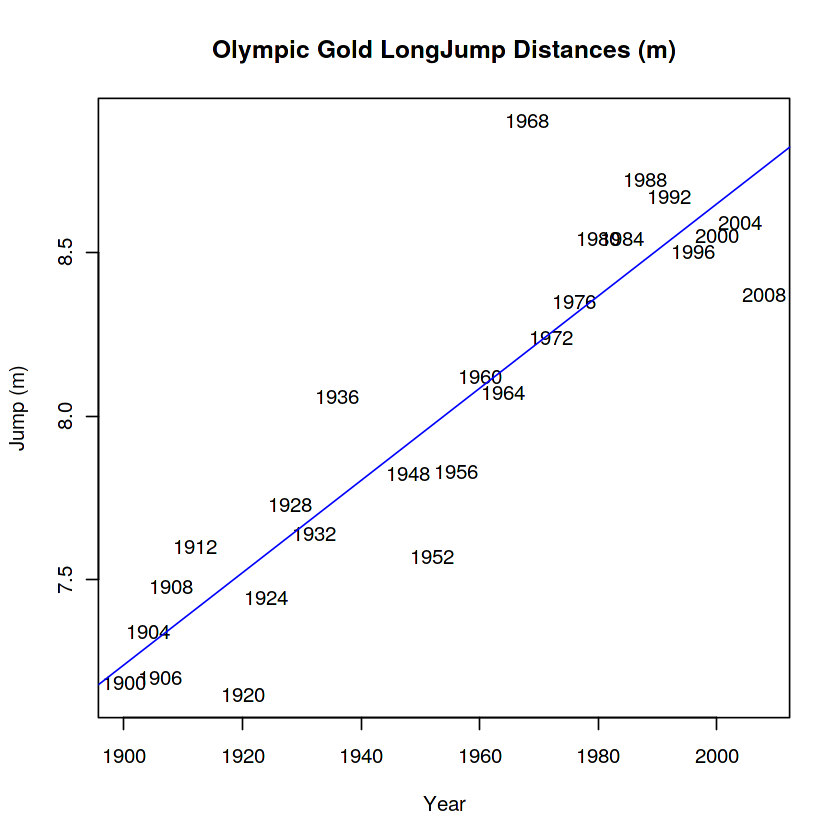

In [18]:
#1.2. Fit simple linear regression model.
m1 <- lm(Jump ~ Year)
summary(m1)
#Plot data with fit overlaid.
par(mfrow=c(1,1))
plot(Jump ~ Year,xlab="Year",ylab="Jump (m)",
     type="n",main="Olympic Gold LongJump Distances (m)",cex=0.6)
text(x=Year,y=Jump,labels=Year)
abline(m1,col="blue")

**1.3.  Based on this model, every 4 years we would expect the jump
distance to change by what amount?**

The coefficient $\beta_1 = 0.014066$ is the predicted
increase in the length of the jump per year, and so the
predicted increase every four years is $0.05626$m.

In [19]:
#1.3. Compute change in winning distance every 4 years
cat("Predicted change every 4 years=",coef(m1)["Year"]*4,"meters \n")

Predicted change every 4 years= 0.05626262 meters 



**1.4.  Plot the residuals against Year (using the `residuals`
function). One year stands out, which one is it?**

The residual plot is shown in the figure below. 1968 is a clear outlier.

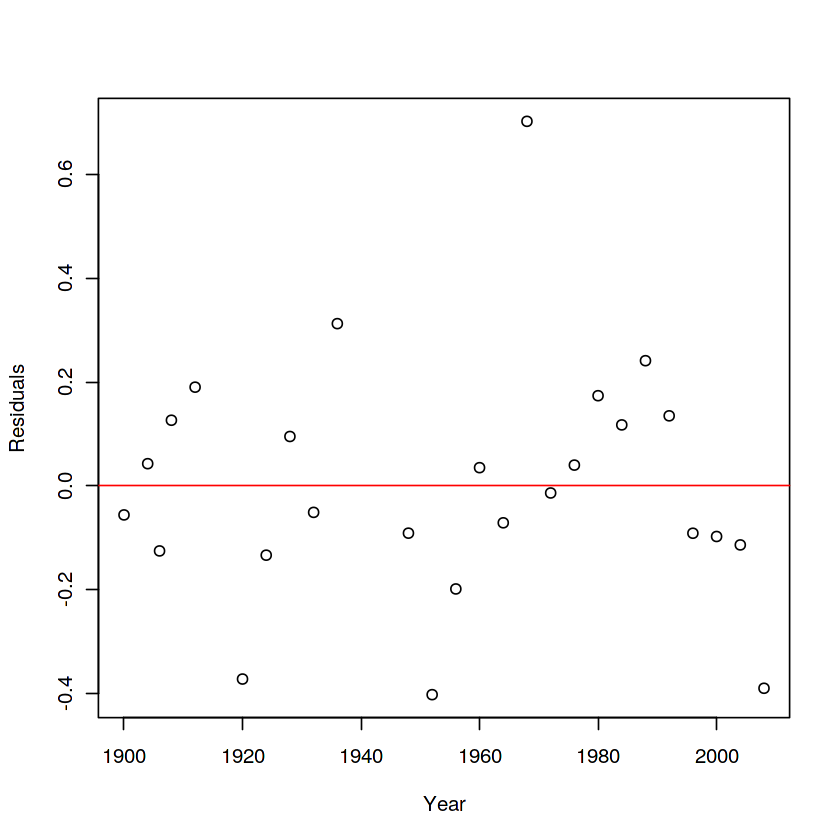

In [20]:
#1.4. Plot residuals against Year
plot(residuals(m1) ~ Year,xlab="Year",ylab="Residuals")
abline(h=0,col="red")

**1.5.  For a more detailed residual analysis, type `par(mfrow=c(2,2))`, and use the `plot` function operating
on the `lm` object (you'll see 4 plots).**

The full set of diagnostic plots are shown in
the figures below. These support the conclusion that 1968
is an outlier.


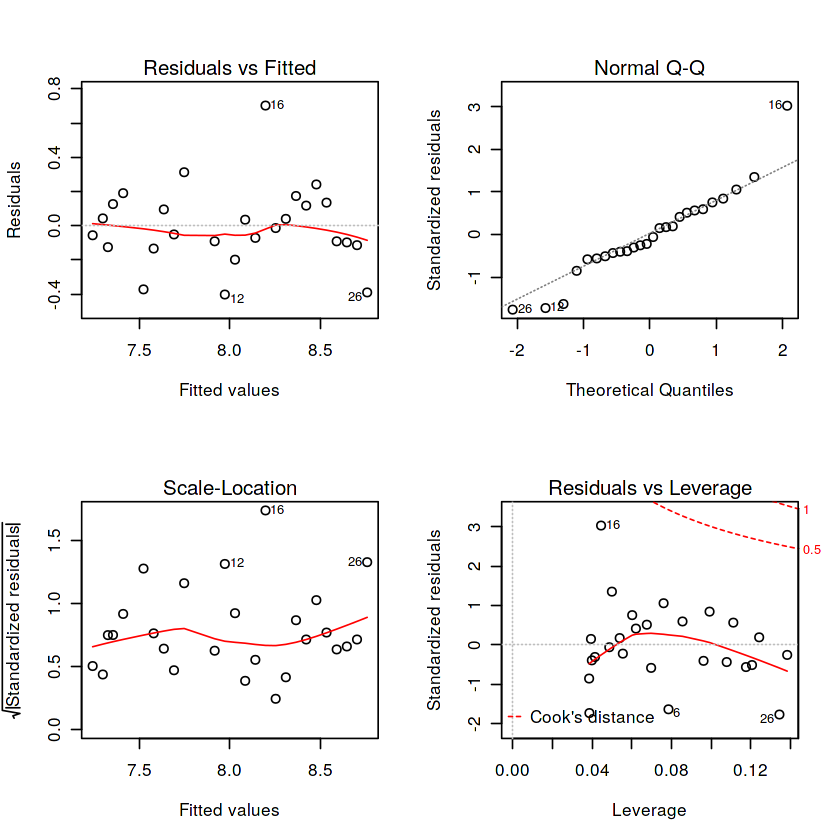

In [21]:
par(mfrow=c(2,2)); plot(m1); par(mfrow=c(1,1))

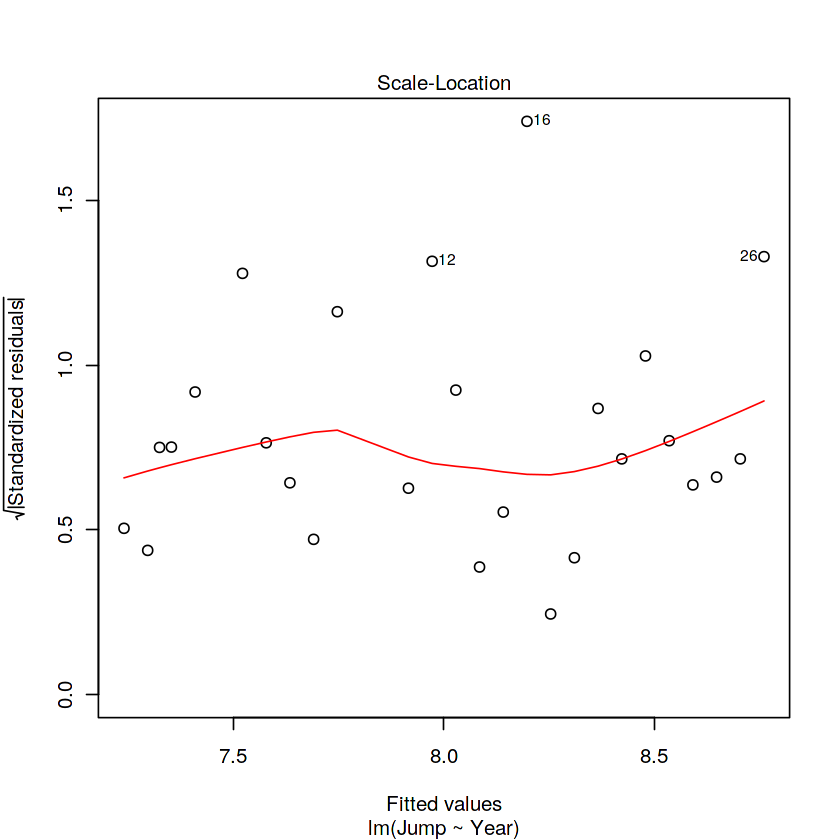

In [22]:
plot(m1,which=3)

**1.6.  Remove the outlier from the data set and refit the model,
then recompute the above residual diagnostics. What do you
observe?**

Diagnostic plots after removing the date point for 1968 are
shown in the figures below. These look much better. The summary
 of the revised fit is also included.


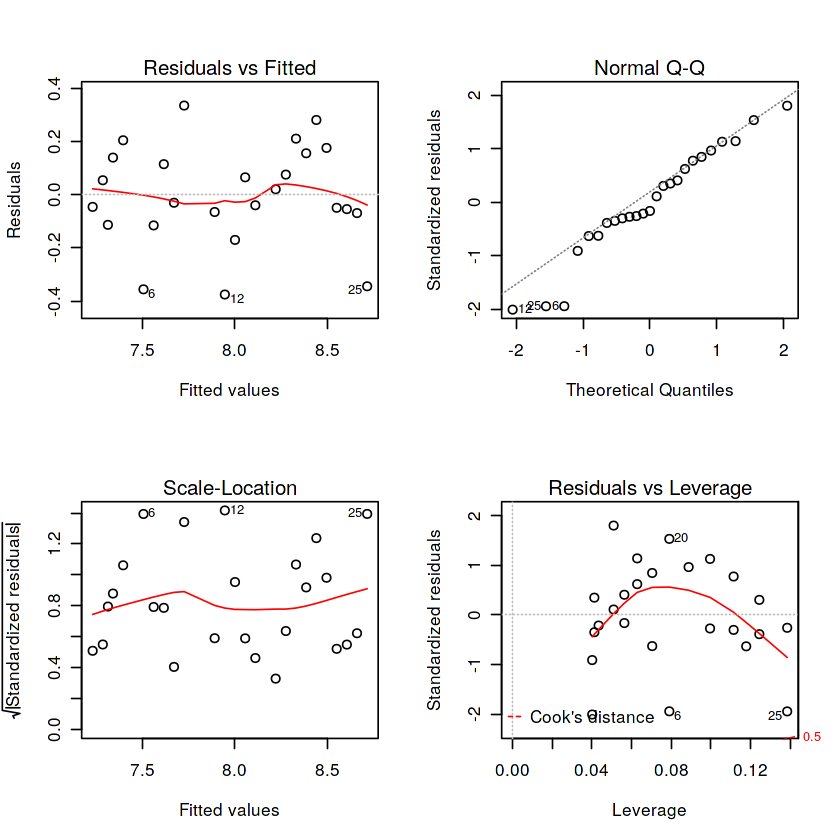

In [23]:
#1.6. Remove outlier and refit
omit <- Year==1968
m2 <- lm(Jump[!omit] ~ Year[!omit])
par(mfrow=c(2,2))
plot(m2)
par(mfrow=c(1,1))

In [24]:
summary(m2)


Call:
lm(formula = Jump[!omit] ~ Year[!omit])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37513 -0.06927 -0.03046  0.13914  0.33460 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -18.862553   2.167089  -8.704 9.79e-09 ***
Year[!omit]   0.013733   0.001109  12.385 1.17e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1908 on 23 degrees of freedom
Multiple R-squared:  0.8696,	Adjusted R-squared:  0.8639 
F-statistic: 153.4 on 1 and 23 DF,  p-value: 1.174e-11


**2.  Carry out a Bayesian linear regression analysis using `rjags`.
As in the frequentist case assume $\epsilon$ $\sim$ Normal(0,
$\sigma^2$). Use the following priors for the three parameters:
$$\begin{aligned}
\beta_0, \beta_1 & \sim & \mbox{Normal} \left ( \mu_0=0, \tau_0=0.001 \right ) \\
\tau & \sim & \mbox{Gamma} \left ( a=0.1, b=0.1 \right )
\end{aligned}$$**

**2.1.  Write the *model* statement, which includes the likelihood
calculation and the prior distribution. Include a
calculation of $\sigma = 1/\sqrt{\tau}$.**

In [25]:
#2.1. Create model block for JAGS
Jump.model <-   
  "model {
  # data that will be read in are n,  Jump, Year and prior hyperparameters
  # prior
  beta0 ~ dnorm(beta.mu.0,beta.tau.0)
  beta1 ~ dnorm(beta.mu.0,beta.tau.0)
  tau   ~ dgamma(tau.a,tau.b)

  #Likelihood
  for(i in 1:n) {
    mu[i]  <- beta0+beta1*Year[i]
    Jump[i] ~ dnorm(mu[i],tau)
  }

  sigma <- 1/sqrt(tau)
 
}"

**2.2.  Create an `R` object for the data, which includes Jump,
   Year, $n$=26 and the values of the prior hyperparameters
   $\mu_0$, $\tau_0$, $a$ and $b$.**

In [26]:
# 2.2. Create data input for JAGS
n     <- length(Year) 
Jump.data <- list(n=n,Jump=Jump,Year=Year,beta.mu.0=0,beta.tau.0=0.001,tau.a=0.1,tau.b=0.1)


**2.3.  Create an `R` object for 3 sets of initial values; such as \
`my.inits <- list(c(b0=0.1,b1=0.2,tau=0.1),
           c(b0=-1,b1=3,tau=0.3),
           c(b0=1,b1=0,tau=.8))`**

In [27]:
# 2.3. Create initial values for JAGS

num.chains <- 3
Jump.inits <- list(list(beta0=0.2, beta1=0.1, tau=0.1),
                   list(beta0=4.0, beta1=0.0, tau=0.01),
                   list(beta0=-3.0,beta1=-2.0,tau=0.001))

**2.4.  Execute `jags.model` using the above objects. Note
`n.chains` should be set equal to 3. How many unobserved
stochastic nodes were there? How many observed?**

In [28]:
# 2.4. Execute JAGS model
# Run JAGS to the completion of the "adaption" stage 
results.A <- jags.model(file=textConnection(Jump.model), 
                        data=Jump.data, inits=Jump.inits, 
                        n.chains=num.chains)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 26
   Unobserved stochastic nodes: 3
   Total graph size: 115

Initializing model



There are 26 observed stochastic nodes, corresponding to
the 26 data points, and 3 unobserved stochastic nodes,
corresponding to the unknown model parameters ($\beta_0$,
$\beta_1$, $\sigma$).

**2.5.  Use `update` to carry out an initial MCMC run (burn-in) with
1,000 iterations.**

In [29]:
# 2.5. Run burn-in
update(results.A, n.iter=1000)

**2.6.  Now make a longer MCMC run using the `coda.samples` function
with 10,000 iterations and have the results for $\beta_0$,
$\beta_1$, and $\sigma$ returned.**

In [30]:
# 2.6. Get production samples

results.B <- coda.samples(results.A, variable.names=c("beta0","beta1","sigma"),n.iter=10000)

**2.7.  Plot the results from `coda.samples`. These are the trace
plots. Do you think that the chains have converged for each
of the 3 parameters?**

The trace plots are shown in the figures below. These show very slow convergence
--- the three separate runs have only just begun to converge at the end of the run.


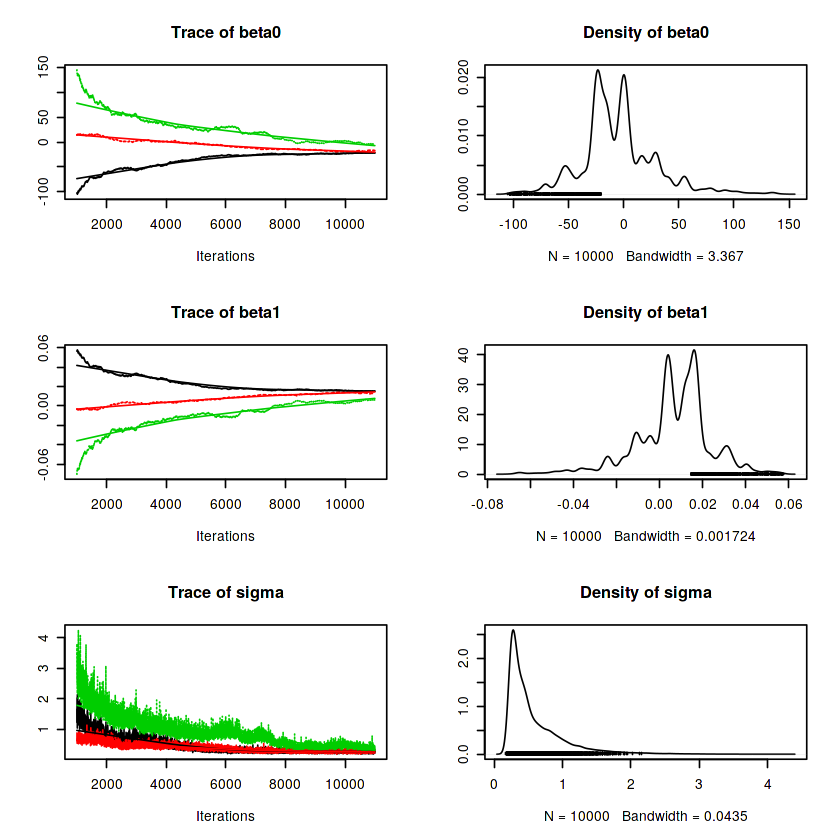

In [31]:
# 2.7. Plot the results to check for convergence
# Check for convergence before looking at posterior dist'n summaries
par(mfrow=c(1,1))
plot(results.B) 

**2.8.  You may have noticed from the trace plots that $\beta_0$ and
$\beta_1$ are mixing slowly. That's indicative of
significant autocorrelation. Use the `acf` function to see
how much correlation there is. For example, if the results
from `coda.samples` are called `res`, for a parameter named
beta0: `acf(res[[1]][,"beta0"],lag.max=100)`**

The autocorrelation functions are shown in the figures below. The autocorrelation is still very
 high, even at lag 100.


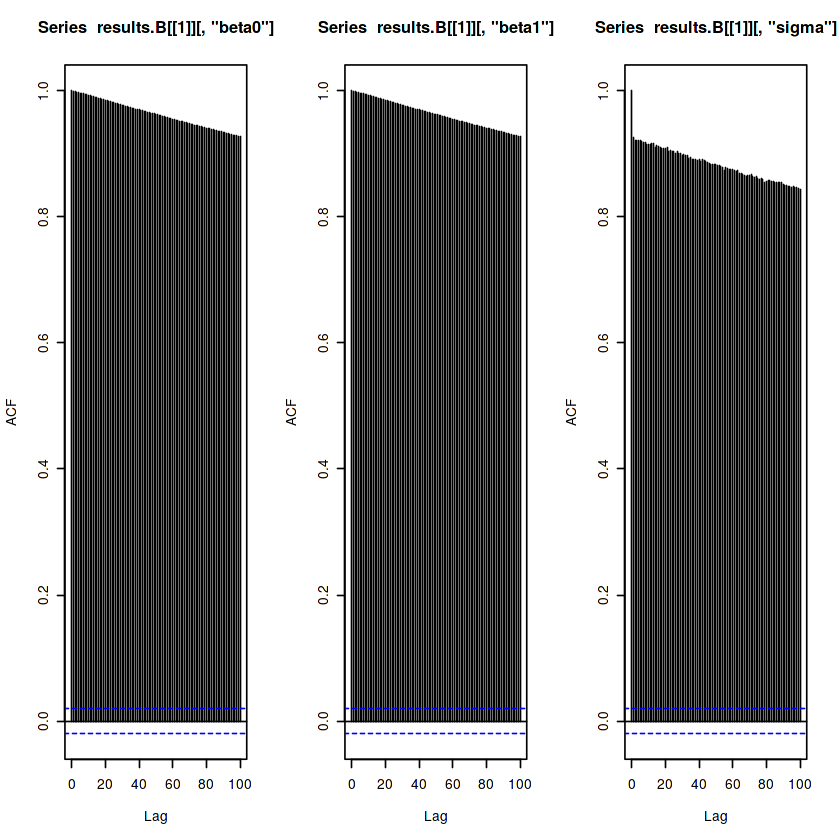

In [32]:
#2.8. Evaluate autocorrelation functions
par(mfrow=c(1,3))
acf(results.B[[1]][,"beta0"],lag.max=100)
acf(results.B[[1]][,"beta1"],lag.max=100)
acf(results.B[[1]][,"sigma"],lag.max=100)

**2.9.  Also take a look at the effective sample sizes per
parameter, e.g.,`effectiveSize(res[[1]][,"beta0"])`**

The 'R' script below computes the effective sample sizes. These are very small, corresponding to poor mixing.

In [33]:
#2.9. Evaluate effective sample sizes for each parameter.
effectiveSize(results.B[[1]][,"beta0"])
effectiveSize(results.B[[1]][,"beta1"])
effectiveSize(results.B[[1]][,"sigma"])

var1 
3.785323

var1 
3.76959

var1 
5.580705

**2.10. In Lecture 2, the Gelman-Rubin (Brooks-Gelman-Rubin)
statistic was discussed. This is a quantitative measure of
apparent convergence that is based upon the degree of
overlap of 2 or more chains after each iteration. The BGR
statistic roughly approximates the ratio of the variability
between chains to the variability within chains (like an F
statistic in ANOVA). The general idea of the statistic is
that the the ratio of those two measures should be around 1
at convergence, thus BGR=1 is "good". Use the `coda` package
function called `gelman.plot` to plot the BGR statistic for
each of the parameters against the MCMC iteration. And use
`gelman.diag` for numerical summaries. What do you think
about convergence now?**

The Gelman-Rubin statistics and plots are shown in the figures below. These show that the BGR is much bigger than $1$ and so the chains have not yet converged, as the trace plots suggested.

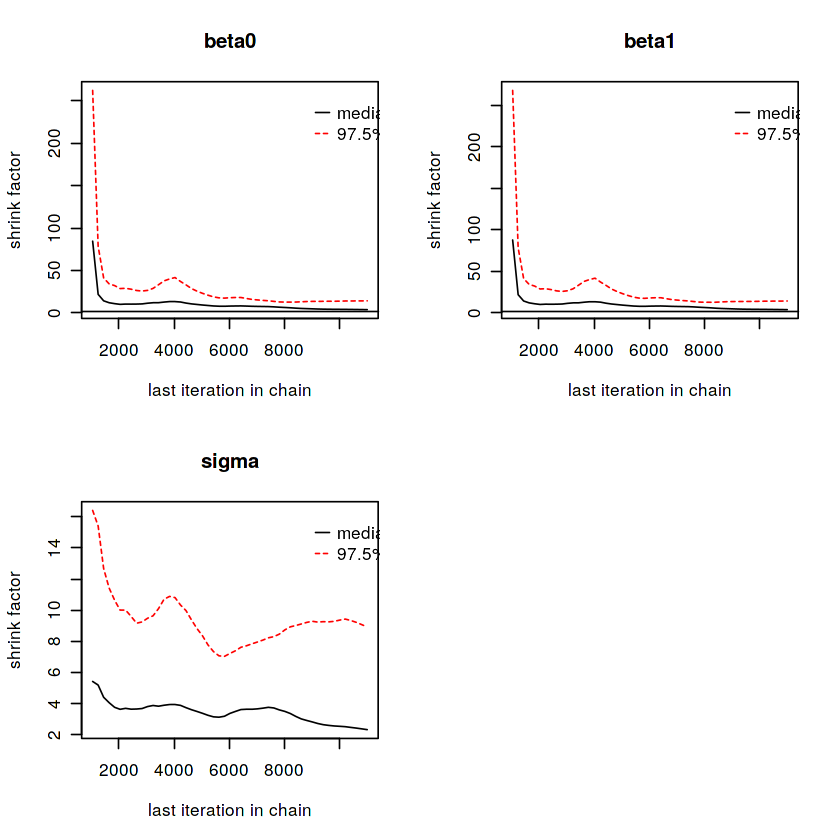

In [34]:
# 2.10. Compute the Gelman-Rubin statistic
par(mfrow=c(2,2))
gelman.plot(results.B)

In [35]:
gelman.diag(results.B)

Potential scale reduction factors:

      Point est. Upper C.I.
beta0       3.68      14.08
beta1       3.68      14.09
sigma       2.33       8.92

Multivariate psrf

3.27

These show that the BGR is much bigger than 1 and so the
chains have not yet converged, as the trace plots suggested.

**2.11. Centring the covariate, in this case Year, sometimes helps
convergence. Modify your Model statement slightly by
creating a new variable `meanY`, and then subtract that from
the `Year[i]` values in the for loop. Repeat the above
steps. How does convergence now look? Use the `summary`
function on the JAGS output to examine the posterior means
and standard deviations for $\beta_0$, $\beta_1$, and
$\sigma$. How do the posterior mean for $\beta_1$ and
$\sigma$ compare to the maximum likelihood estimates
obtained in 1.2?**

 The trace plots, autocorrelation functions and Gelman-Rubin
 statistics for the regression after centring are shown in
 the figures below. These show much better convergence than the
 previous results.

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 26
   Unobserved stochastic nodes: 3
   Total graph size: 143

Initializing model



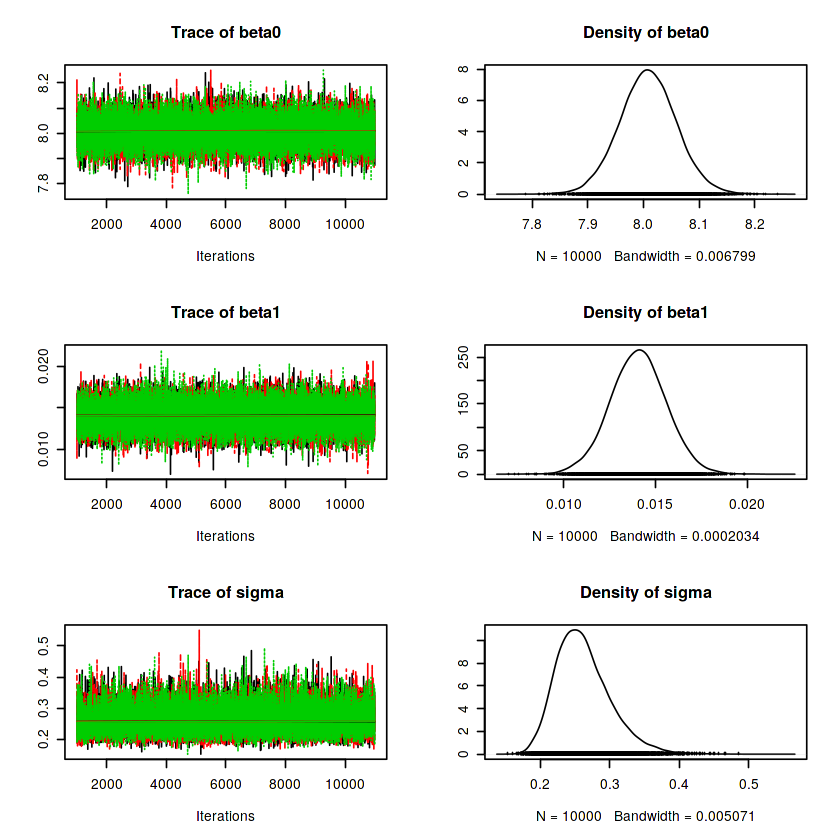

Potential scale reduction factors:

      Point est. Upper C.I.
beta0          1          1
beta1          1          1
sigma          1          1

Multivariate psrf

1

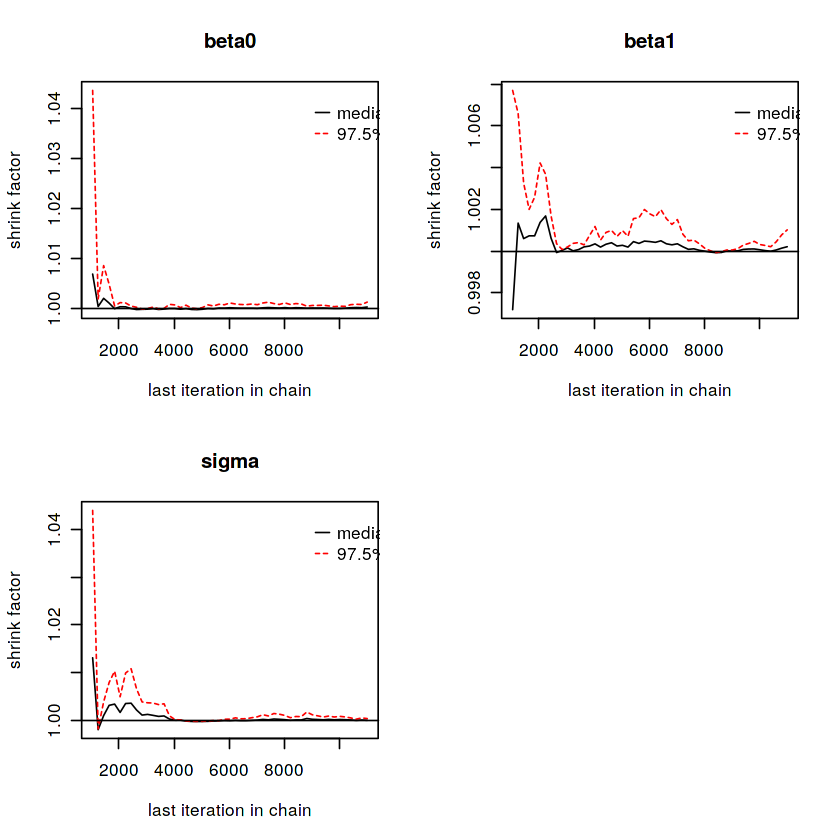

ESS for parameter beta0: 10000 
ESS for parameter beta1: 10000 
ESS for parameter sigma: 8362.137 



Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
beta0 8.00825 0.05159 2.979e-04      2.978e-04
beta1 0.01406 0.00153 8.836e-06      8.836e-06
sigma 0.26157 0.03944 2.277e-04      2.493e-04

2. Quantiles for each variable:

         2.5%     25%     50%     75%   97.5%
beta0 7.90676 7.97425 8.00805 8.04181 8.11080
beta1 0.01102 0.01305 0.01407 0.01507 0.01707
sigma 0.19808 0.23371 0.25676 0.28409 0.35277


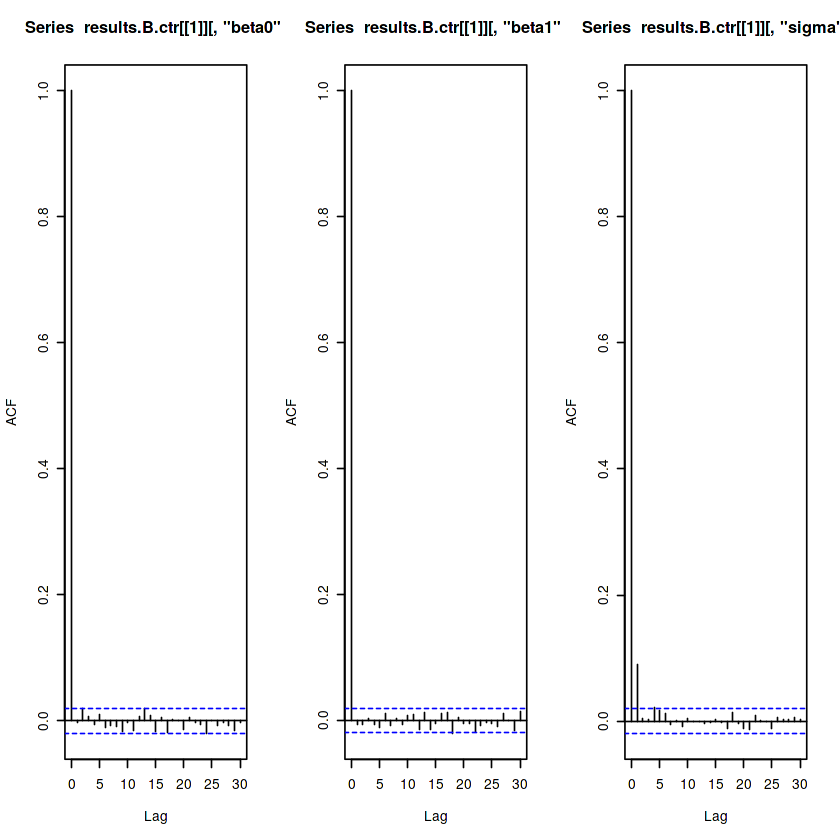

In [36]:
#2.11. Work with centered covariate to see if that helps----
Jump.ctr.model <-   
  "model {
  # prior
  beta0 ~ dnorm(beta.mu.0,beta.tau.0)
  beta1 ~ dnorm(beta.mu.0,beta.tau.0)
  tau   ~ dgamma(tau.a,tau.b)
  meanY <- mean(Year)

  #Likelihood
  for(i in 1:n) {
    mu[i]  <- beta0+beta1*(Year[i]-meanY)
    Jump[i] ~ dnorm(mu[i],tau)
  }

  sigma <- 1/sqrt(tau)
 
}"

# Run JAGS to the completion of the "adaption" stage 
results.A.ctr <- jags.model(file=textConnection(Jump.ctr.model), 
                        data=Jump.data, inits=Jump.inits, 
                        n.chains=num.chains)
update(results.A.ctr, n.iter=1000)
results.B.ctr <- coda.samples(results.A.ctr, variable.names=c("beta0","beta1","sigma"),
                              n.iter=10000)

plot(results.B.ctr) 
gelman.plot(results.B.ctr)
gelman.diag(results.B.ctr)


par(mfrow=c(1,3))
acf(results.B.ctr[[1]][,"beta0"],lag.max=30)
acf(results.B.ctr[[1]][,"beta1"],lag.max=30)
acf(results.B.ctr[[1]][,"sigma"],lag.max=30)


par(mfrow=c(1,1))

#effective sample size
cat("ESS for parameter beta0:", effectiveSize(results.B.ctr[[1]][,"beta0"]),"\n")
cat("ESS for parameter beta1:",effectiveSize(results.B.ctr[[1]][,"beta1"]),"\n")
cat("ESS for parameter sigma:",effectiveSize(results.B.ctr[[1]][,"sigma"]),"\n")

summary(results.B.ctr)


**3.1.  *Robustifying the regression.* As was noted in Lecture 2, the
effects of extreme observations or "outliers" on regressing
results can be diminished by using a $t$ distribution for the
observations. For simplicity, assume a $t$ distribution with 3
df for the distribution of errors. Revise the JAGS model code
accordingly (continuing to work with the centred covariate) and
re-run. Recall from Lecture 3 that the necessary change to the
code is to replace `dnorm` with `dt` and add an additional
argument to `data` for the df (=3). How did the posterior mean
of $\beta_1$ change? Compare it to the estimate in
1.2 when the extreme observation is removed.**

The figure below shows the trace plots for a Bayesian robust regression fit to
the longjump data.

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 26
   Unobserved stochastic nodes: 3
   Total graph size: 144

Initializing model




Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean       SD  Naive SE Time-series SE
beta0 7.99870 0.047284 2.730e-04      3.570e-04
beta1 0.01395 0.001371 7.915e-06      1.021e-05
sigma 0.20731 0.037974 2.192e-04      3.062e-04

2. Quantiles for each variable:

         2.5%     25%     50%     75%  97.5%
beta0 7.90542 7.96759 7.99863 8.03013 8.0917
beta1 0.01127 0.01305 0.01393 0.01484 0.0167
sigma 0.14559 0.18072 0.20282 0.22884 0.2945


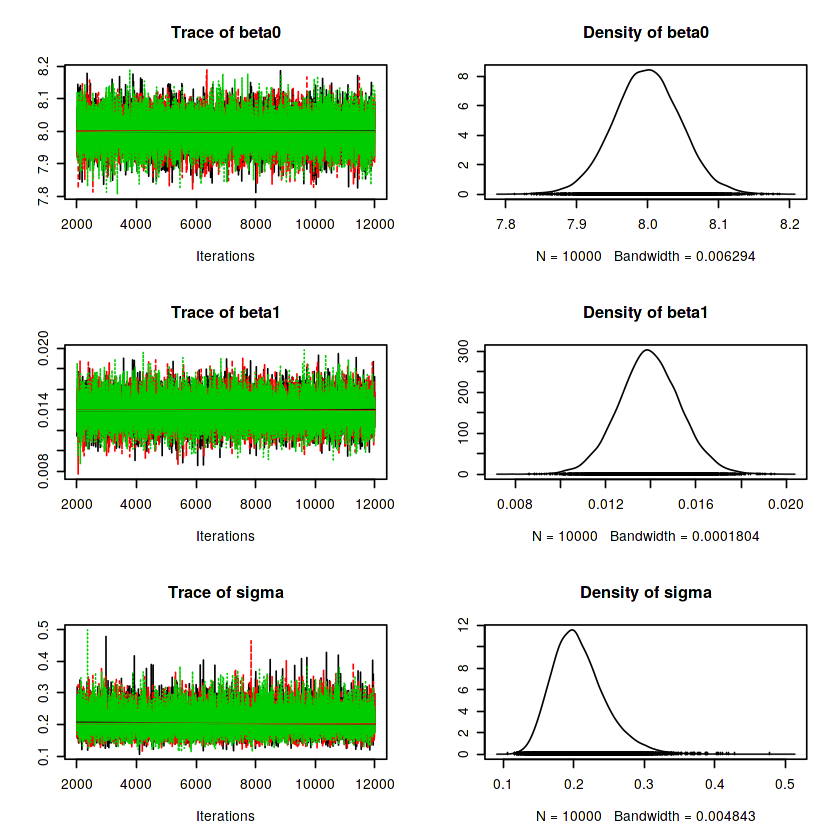

In [37]:
# 3.1. Robustifying the model
Jump.ctr.robust.model <-   
  "model {
  # prior
  beta0 ~ dnorm(beta.mu.0,beta.tau.0)
  beta1 ~ dnorm(beta.mu.0,beta.tau.0)
  tau   ~ dgamma(tau.a,tau.b)
  meanY <- mean(Year)

  #Likelihood
  for(i in 1:n) {
    mu[i]  <- beta0+beta1*(Year[i]-meanY)
    Jump[i] ~ dt(mu[i],tau,df)
  }

  sigma <- 1/sqrt(tau)
 
}"
#Add degrees of freedom parameter to data list
Jump.robust.data <- list(n=n,Jump=Jump,Year=Year,beta.mu.0=0,beta.tau.0=0.001,tau.a=0.1,tau.b=0.1,df=3)

# Run JAGS to the completion of the "adaption" stage 
results.A.robust <- jags.model(file=textConnection(Jump.ctr.robust.model), 
                        data=Jump.robust.data, inits=Jump.inits, 
                        n.chains=num.chains)
update(results.A.robust, n.iter=1000)
results.B.robust <- coda.samples(results.A.robust, variable.names=c("beta0","beta1","sigma"),
                              n.iter=10000)
plot(results.B.robust)

summary(results.B.robust)

# Aside: If add data for the last 2 Olympics--- 
# y.jump <- c(LongJumpOlympics$Gold,8.31,8.38)
# x.year <- c(LongJumpOlympics$Year,2012,2016)
# plot(y.jump ~ x.year,xlab="Year",ylab="Jump (m)",
#      type="n",main="Olympic Gold LongJump Distances (m)",cex=0.7)
# text(x.year,y.jump,x.year)
# see a decline in distances, not as linear either


The new posterior mean estimate of $\beta_1$ is $0.0139$, which
compares well to the value derived from the least squares fit
after removing the outlier ($0.0137$). The posterior mean
estimate of $\sigma$ ($0.208$) is somewhat larger than the least
squares estimate ($0.191$), but the meaning of the parameter is
now somewhat different.

**3.  Nonlinear Regression. Newton's law of cooling, from Bates and Watts (2008)**

**The following data are measurements over a 41 minute period of the
temperature of a bore after that bore had been rubbed inside "a
stationary cylinder and pressed against the bottom by means of a
screw". The bore was turned by a team of horses (this is an
experiment with friction from 1798 by a Count Rumford).**


In [38]:
 #minutes
 elapsed.time <- c(4,5,7,12,14,16,20,24,28,31,34,37.5,41) 
 #Fahrenheit
 temperature <- c(126,125,123,120,119,118,116,115,114,113,112,111,110) 
 n <- length(elapsed.time)


**An underlying theoretical model based on Newton's law of cooling
suggests that temperature should decline over time according to the
following model. 
$$\begin{aligned}
\mbox{temperature} & = & 60 +70e^{-\theta \;\mbox{elapsed.time}}
\end{aligned}$$
You are to evaluate this model, i.e., make
estimates of $\theta$ using classical and Bayesian techniques.**

**(i)  Plot temperature against time (use the `scatter.smooth` function
to draw a nonparametric regression line through the points).**

The plot of temperature versus elapsed time is shown
in the figure below.

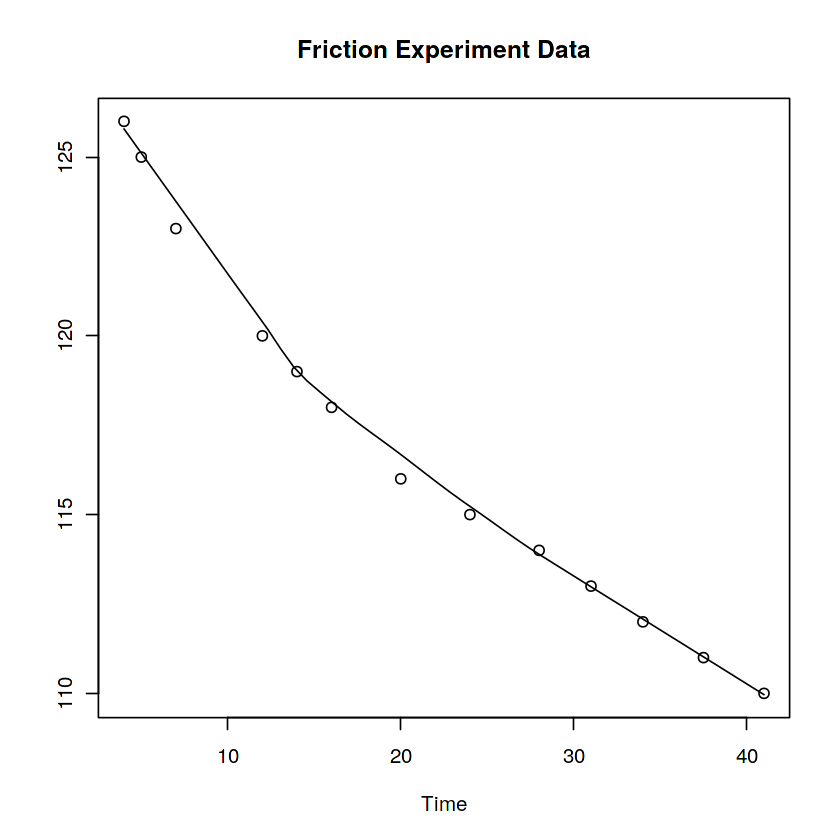

In [39]:
# (i)  Plot Temperature vs Time
scatter.smooth(temperature ~ elapsed.time,xlab="Time",ylab="",main="Friction Experiment Data")

**(ii). Fit the model in (i) using a classical approach that assumes that 
observations have model errors are iid
Normal(0,$\sigma^2$). 
$$\begin{aligned}
 \mbox{temperature} & \sim & \mbox{Normal} \left ( 60 +70e^{-\theta \; \mbox{elapsed.time}}, \sigma^2 \right )
\end{aligned}$$
Use the `nls` function in R. The format of
`nls` in this case: `nl.1 <- nls(formula= temperature ~ 60 + 70*exp(-theta*elapsed.time), start=list(theta=initial.theta))`**
**where `initial.theta` is an initial guess as to what $\theta$ is.**

**One way to get an estimate of $\theta$ is to "linearize"
Newton's law of cooling as follows: 
$$\begin{aligned}
-\ln \left ( \frac{(\mbox{temperature}-60)}{70} \right )  & = &  \theta*\mbox{elapsed.time}
\end{aligned}$$
and then fit the resulting linear model
with the `lm` function.**

In [40]:
y <- -log((temperature-60)/70)
out <- lm(y ~ 0 + elapsed.time)  

**Use the estimated coefficient in `out` as the value of
`initial.theta`. After fitting the model, plot the fit and
the observations.**

Please see the `R` script below where this procedure was implemented, the value of initial.theta and the final fit is printed out, as well as a summary of the nonlinear least squares fit.

In [41]:
# (ii) Compute nonlinear least squares estimate
# estimate an initial value for theta
y <- -log((temperature-60)/70)
out <- lm(y ~ -1 + elapsed.time)
initial.theta <- coef(out)
cat("initial.theta:",initial.theta,"\n")

nl.1 <- nls(formula= temperature ~ 60 + 70*exp(-theta*elapsed.time),
             start=list(theta=initial.theta))
cat("Estimated theta=",signif(coef(nl.1),4),"\n")

summary(nl.1)  # sigma.hat = 1.918

initial.theta: 0.009217199 
Estimated theta= 0.009415 



Formula: temperature ~ 60 + 70 * exp(-theta * elapsed.time)

Parameters:
       Estimate Std. Error t value Pr(>|t|)    
theta 0.0094155  0.0004201   22.41 3.67e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.918 on 12 degrees of freedom

Number of iterations to convergence: 3 
Achieved convergence tolerance: 3.399e-07


The plot below shows the fitted curve along with the data.

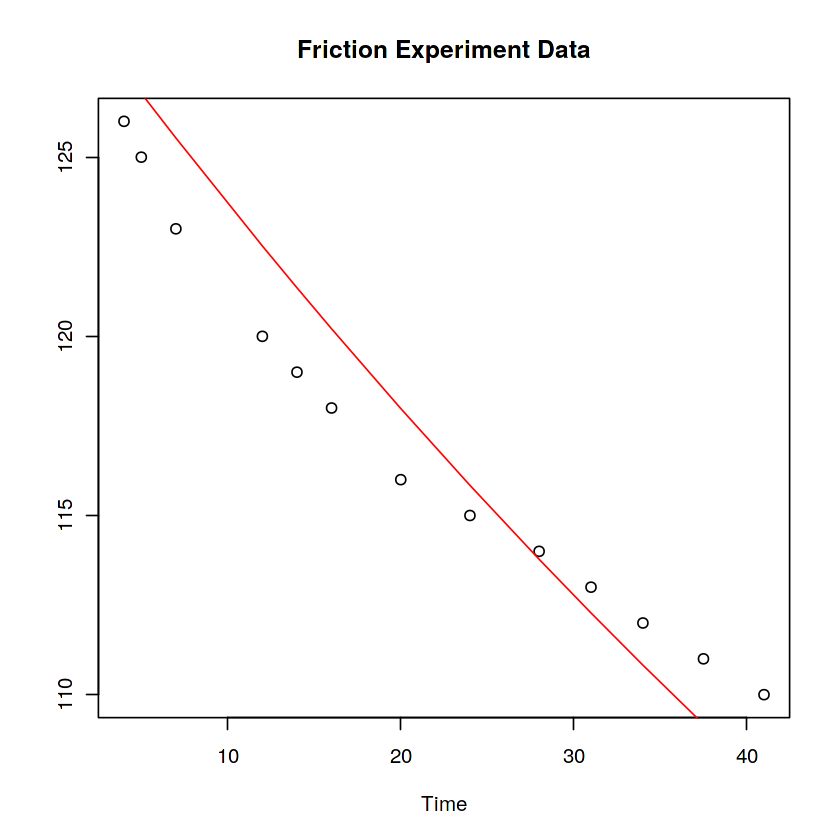

In [42]:
plot(temperature ~ elapsed.time,xlab="Time",ylab="",
main="Friction Experiment Data")
lines(elapsed.time,fitted(nl.1),col="red")

**How does the fit look?**

The fit is clearly not a good representation of the observations.

**(iii) Instead of using 60 and 70 in Newton's law of cooling as known values, refit the model
estimating the coefficients.**

Fitting the additional coefficients as well we obtain the following results.

beta0        beta1        theta 
106.19504739  22.91607188   0.04095401


Formula: temperature ~ beta0 + beta1 * exp(-theta * elapsed.time)

Parameters:
       Estimate Std. Error t value Pr(>|t|)    
beta0 1.062e+02  1.015e+00  104.63  < 2e-16 ***
beta1 2.292e+01  7.663e-01   29.91 4.09e-11 ***
theta 4.095e-02  4.073e-03   10.05 1.51e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3418 on 10 degrees of freedom

Number of iterations to convergence: 11 
Achieved convergence tolerance: 2.803e-06


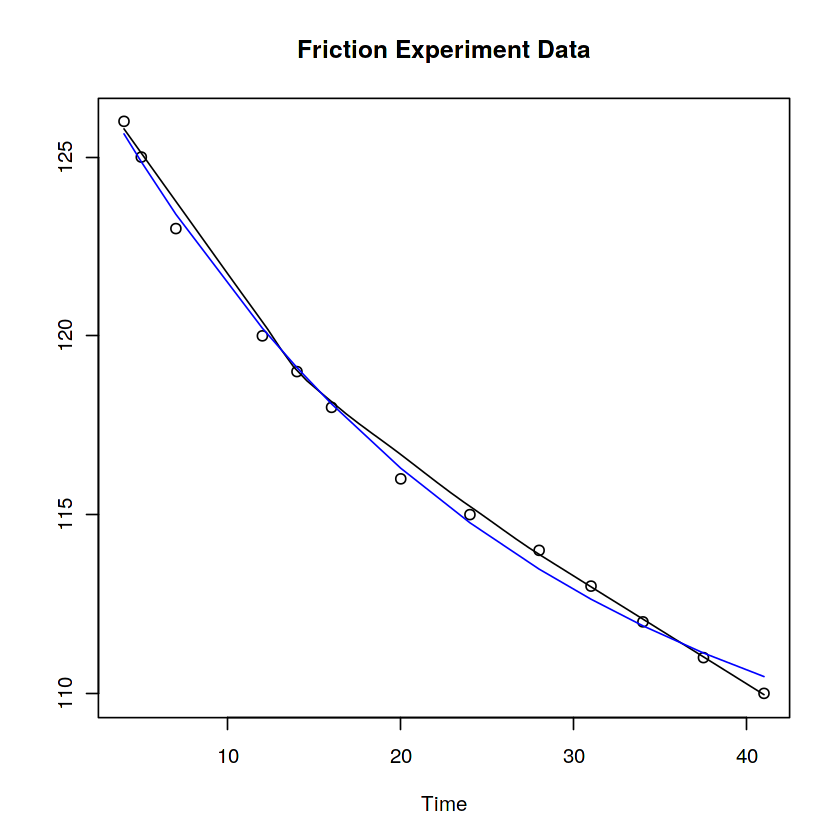

In [43]:
nl.2 <- nls(formula=temperature ~ beta0 + beta1*exp(-theta*elapsed.time),
            start=list(beta0=50,beta1=50,theta=initial.theta))
coef(nl.2)
summary(nl.2)
scatter.smooth(temperature ~ elapsed.time,xlab="Time",ylab="",main="Friction Experiment Data")
lines(elapsed.time,fitted(nl.2),col="blue") 

**Compare the estimated coefficients to the assumed values and
plot the fitted line over the top of the previous plot. Has the
fit improved?**

The best-fit coefficients, $106.2$ and $22.9$, differ
considerably from the assumed values of $60$ and $70$. The
residual standard error is now much smaller and the fit matches
the data much better, as shown in the figure above.

**(iv) Use JAGS to fit two Bayesian nonlinear regression models: one
based on Newton's law of cooling, as in (ii), and another where all three
coefficients are estimated, as in (iii). Assume that temperatures are
normally distributed in the likelihood model.**

**In both cases use exponential distributions for the priors for
$\theta$ and then for $\beta_0$ and $\beta_1$ (to ensure that
the posterior distributions are positive valued). To pick the
exponential distribution hyperparameter, say $\alpha$, note that
if $X \sim$Exp$(\alpha)$, $\mathbb{E}[X]$ = $1/\alpha$. Pick a
large value for the hyperparameter for $\theta$ such that the
expected value of $\theta$ is less than 1. For the 2nd model (as in (iii)), select hyperparameter values for  $\beta_0$ and $\beta_1$ such that the expected values are 60 and
70, respectively. Note: in JAGS, the exponential density is
written `theta ~ dexp(a)` given hyperparameter $a$.**

**Compare the posterior means for $\theta$ in both models with the
frequentist estimates.\
Likewise compare the posterior means for
$\beta_0$ and $\beta_1$ for the second model.**


First, we fit the Bayesian model with $\beta_0$ and $\beta_1$ fixed at 60 and 70, respectively.

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 13
   Unobserved stochastic nodes: 2
   Total graph size: 90

Initializing model




Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean        SD  Naive SE Time-series SE
sigma 2.049346 0.4683176 2.704e-03      3.126e-03
theta 0.009403 0.0004639 2.678e-06      3.542e-06

2. Quantiles for each variable:

          2.5%     25%      50%      75%   97.5%
sigma 1.371376 1.71928 1.974008 2.286350 3.18289
theta 0.008491 0.00911 0.009401 0.009693 0.01033


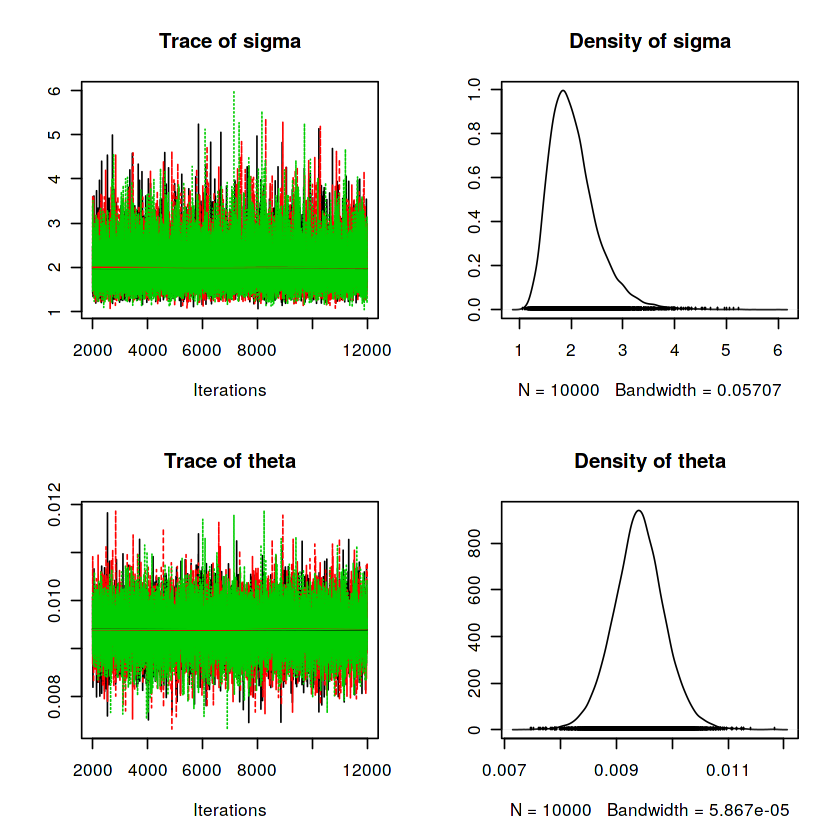

In [44]:
# (iv) Bayesian model 
Friction.model <-   
  "model {
  # data that will be read in are n,  temperature, elapsed.time and prior hyperparameters
  # prior
  theta ~ dexp(theta.0)
  tau  ~ dgamma(tau.a,tau.b)
 
  #Likelihood
  for(i in 1:n) {
    mu[i]  <- 60+70*exp(-theta*elapsed.time[i])
    temperature[i] ~ dnorm(mu[i],tau)
  }

  sigma <- 1/sqrt(tau)
}"

num.chains <- 3

friction.data <- list(temperature=temperature,elapsed.time=elapsed.time,n=n,theta.0=100,tau.a=0.01,tau.b=0.01)
friction.inits <- list(list(theta=0.1,tau=0.1),
                       list(theta=0.2,tau=0.1),
                       list(theta=0.2,tau=0.2))
results.friction.A<- jags.model(file=textConnection(Friction.model), 
                               data=friction.data, inits=friction.inits, 
                               n.chains=num.chains)
update(results.friction.A, n.iter=1000)
results.friction.B <- coda.samples(results.friction.A, 
          variable.names=c("theta","sigma"), n.iter=10000)
plot(results.friction.B)

summary(results.friction.B)  
 

The trace plots show that the chains were mixing well and
have converged. The posterior mean estimate of $\theta$ is
$0.0094$, which agrees with the estimate obtained in question
(ii).

Now we fit the second model, where parameters $\beta_0$ and $\beta_1$ are also allowed to vary.

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 13
   Unobserved stochastic nodes: 4
   Total graph size: 92

Initializing model




Iterations = 2001:52000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean       SD  Naive SE Time-series SE
beta0 105.54000 1.333146 3.442e-03      0.0605391
beta1  23.39673 1.043332 2.694e-03      0.0439716
sigma   0.37533 0.095051 2.454e-04      0.0009906
theta   0.03897 0.004566 1.179e-05      0.0001858

2. Quantiles for each variable:

           2.5%       25%       50%       75%    97.5%
beta0 102.38722 104.81504 105.71642 106.45444 107.6716
beta1  21.74906  22.69324  23.24955  23.94247  25.8904
sigma   0.24155   0.30887   0.35859   0.42269   0.6074
theta   0.02971   0.03601   0.03906   0.04197   0.0478


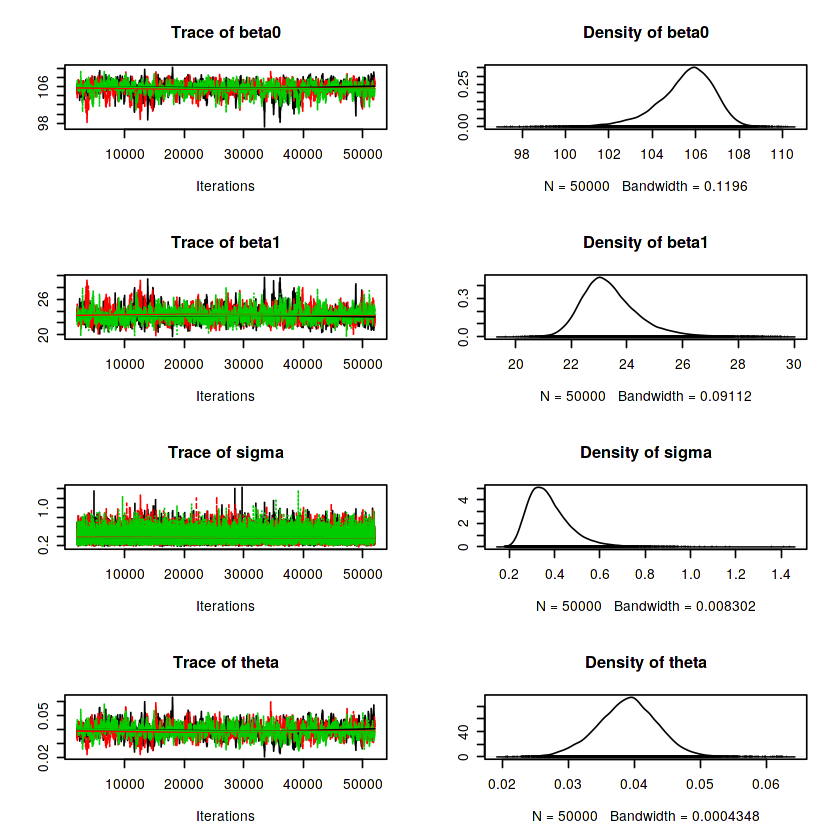

In [45]:
# Now fit all three parameters in the model
Friction.3par.model <-   
  "model {
# data that will be read in are n,  temperature, elapsed.time and prior hyperparameters
# prior
theta ~ dexp(theta.0)
beta0 ~ dexp(beta0.0)
beta1 ~ dexp(beta1.0)
tau  ~ dgamma(tau.a,tau.b)

#Likelihood
for(i in 1:n) {
mu[i]  <- beta0+beta1*exp(-theta*elapsed.time[i])
temperature[i] ~ dnorm(mu[i],tau)
}

sigma <- 1/sqrt(tau)

}"

friction.3par.data <- list(temperature=temperature,elapsed.time=elapsed.time,n=n,theta.0=100,beta0.0=1/60,beta1.0=1./70,tau.a=0.01,tau.b=0.01)
friction.3par.inits <- list(list(theta=0.1,beta0=1, beta1=10,tau=0.1),
                       list(theta=0.2,beta0=50,beta1=80,tau=0.1),
                       list(theta=0.2,beta0=100,beta1=100,tau=0.2))
results.friction.3par.A<- jags.model(file=textConnection(Friction.3par.model), 
                               data=friction.3par.data, inits=friction.3par.inits, 
                               n.chains=num.chains)
update(results.friction.3par.A, n.iter=1000)
results.friction.3par.B <- coda.samples(results.friction.3par.A, 
          variable.names=c("theta","beta0","beta1","sigma"), n.iter=50000)
plot(results.friction.3par.B)
summary(results.friction.3par.B)

Again, the trace plots show good convergence. The posterior mean estimates of $\theta$
($0.0388$), $\beta_0$ ($105.4$) and $\beta_1$ ($23.5$) agree
within their uncertainties with those obtained from the
non-linear least squares fit, which were $0.0409$, $106.2$ and
$22.9$ respectively.

**4.  Multiple Linear Regression\
Factors Affecting Extinction Times of 62 Land Bird Species,
adapted from Albert, 2009\
The data are taken from Ramsey and Schafer (1997), who took them
from Pimm et al. 1988, and are available in the `LearnBayes` package
as the object `birdextinct`. Land birds on 16 small islands had been
observed annually during breeding surveys over a period of several
decades. Some 62 species went extinct at some point and the
objective is to examine the relationship between the years till
extinction and three different covariates: the initial average
number of nesting pairs observed (`nesting`), the physical size of
the birds (an indicator variable `size` with 1=small and 0=large),
and migratory status (an indicator variable `status` with
1=resident, 0=migratory).**

**To begin, do the following in `R`.**



In [46]:
library(LearnBayes)
data(birdextinct)
n   <- nrow(birdextinct)
extinct.time <- birdextinct$time
avg.no.nests <- birdextinct$nesting
size.ind  <- birdextinct$size   # 0 = large, 1= small
mig.ind   <- birdextinct$status # 0 = mig, 1=resident
size                             <- rep("Small",n)
size[birdextinct$size==0]        <- "Large"
migratory                        <- rep("Resident",n)
migratory[birdextinct$status==0] <- "Migratory"  

**1.  Exploratory data analysis and data transformation**

**1.1.  Look at the histogram of `extinct.time`. It is strongly
right skewed (there are few species with times till
extinction that are long relative to most species).
Therefore make the response variable the natural log of
exinct.time:**

The histogram is shown below. As stated in the problem sheet, the
distribution shows a strong right skew --- there is a large
peak at short extinction times, and then a long tail of low
frequency out to quite large extinction times.

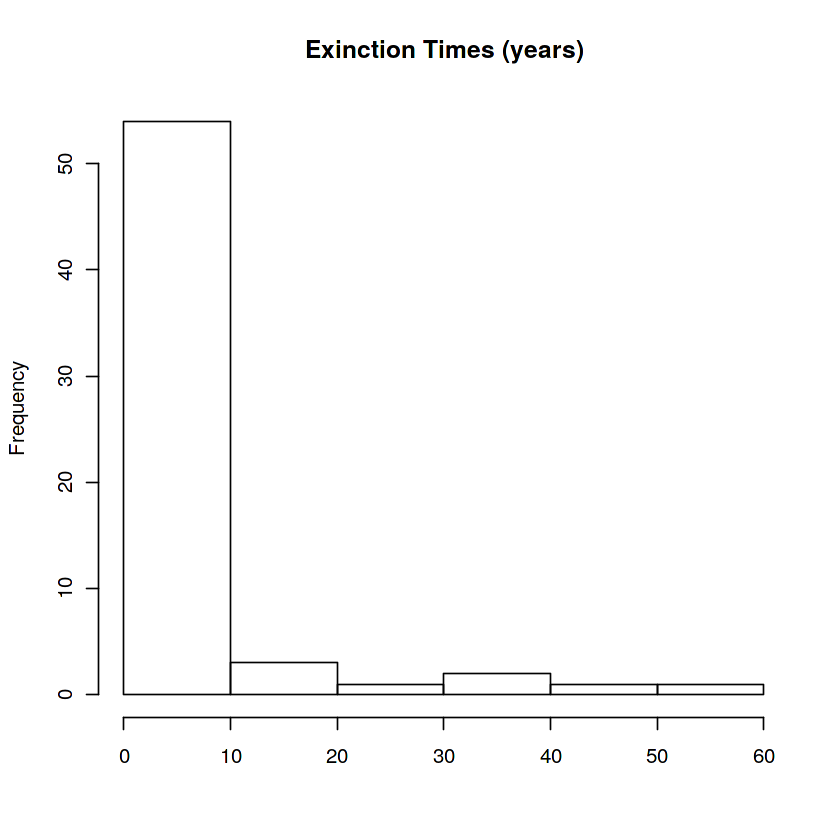

In [47]:
hist(extinct.time,xlab="",main="Exinction Times (years)")

log.extinct <- log(extinct.time)

**1.2.  Make 4 plots of $y$=`log.extinct`: histogram of $y$,
scatterplot of $y$ against `avg.nests`, side-by-side
boxplots of $y$ for small and large birds, and side-by-side
boxplots of resident and migratory birds. Hint:  To make side-by-side boxplots use the `split` function; e.g.,`boxplot(split(log.extinct,size),main=’vs Size’)`**

The suggested summary plots for the log extinction data are
shown in the figure below.

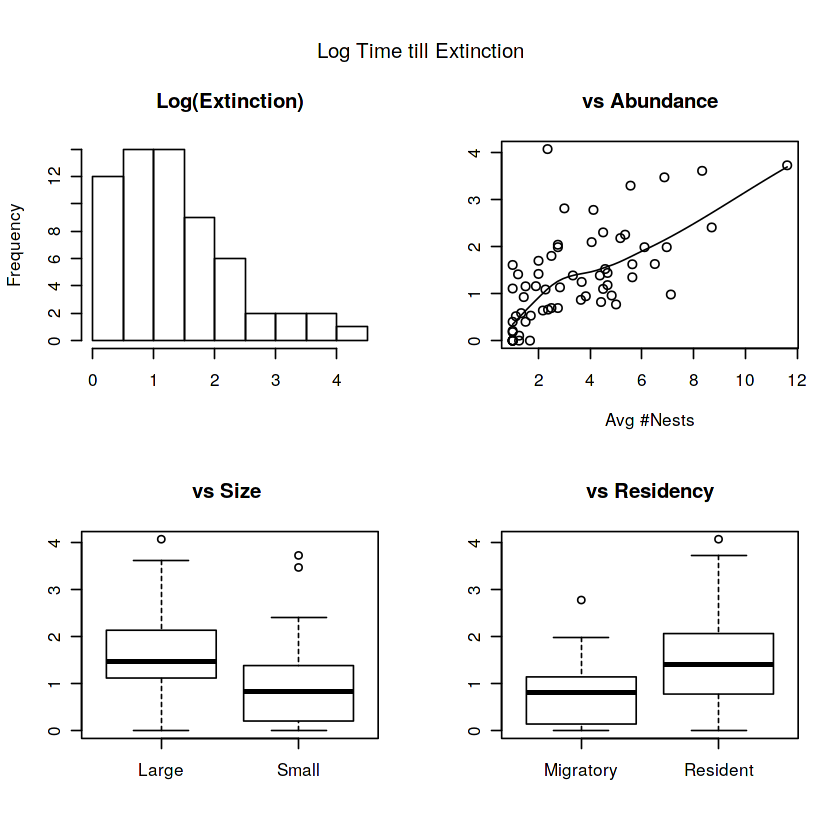

In [48]:
par(mfrow=c(2,2),oma=c(0,0,3,0))
hist(log.extinct,xlab="",main="Log(Extinction)")
scatter.smooth(log.extinct ~ avg.no.nests,xlab="Avg #Nests",ylab="",
      main="vs Abundance")
boxplot(split(log.extinct,size),main="vs Size ")
boxplot(split(log.extinct,migratory),main="vs Residency")
 mtext("Log Time till Extinction",outer=TRUE)

par(mfrow=c(1,1)) 

The plots above are Exploratory Data Analysis for the bird extinction data, using the logarithm
of the extinction time as the dependent variable. The plots
show a histogram of the extinction time (top left), a
scatter plot of extinction time versus average number of
nests (top right) and box plots of extinction time versus
size (bottom left) and versus residence type (bottom
right).

**1.3.  How would you describe the relationships between the 3
covariates and time till extinction?**

The plot of log-extinction time versus average number of
nests shows a clear trend, to increase a the number of
nests increases, and the relationship is reasonably linear.
There is also a clear trend for the extinction time to
decrease for small birds versus large birds, and for it to
increase for resident birds versus those that are
migratory.

**2. Fit a classical multiple linear regression of the `log.extinct`
on the three covariates,**

In [49]:
extinct.mlr <- lm(log.extinct ~ avg.no.nests + size + migratory)

**2.1 Examine the estimated coefficients. How do they compare to your
 conclusions from the EDA (Exploratory Data Analysis)?**

In [50]:
summary(extinct.mlr)


Call:
lm(formula = log.extinct ~ avg.no.nests + size + migratory)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8410 -0.2932 -0.0709  0.2165  2.5167 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.43087    0.20706   2.081 0.041870 *  
avg.no.nests       0.26501    0.03679   7.203 1.33e-09 ***
sizeSmall         -0.65220    0.16667  -3.913 0.000242 ***
migratoryResident  0.50417    0.18263   2.761 0.007712 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6524 on 58 degrees of freedom
Multiple R-squared:  0.5982,	Adjusted R-squared:  0.5775 
F-statistic: 28.79 on 3 and 58 DF,  p-value: 1.577e-11


As we expected from looking at the figures above, there is a
relationship between the time to extinction and all three of the
covariates, so all of the fit coefficients are significant. The
direction of the trends are also as expected --- extinction time
increases with the average number of nests, the size of the bird
and if it is resident rather than migratory.

Note we could also centre the average number of nests variable
before fitting which gives similar conclusions



Call:
lm(formula = log.extinct ~ nest.ctr + size + migratory)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8410 -0.2932 -0.0709  0.2165  2.5167 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.33636    0.17919   7.458 4.99e-10 ***
nest.ctr           0.26501    0.03679   7.203 1.33e-09 ***
sizeSmall         -0.65220    0.16667  -3.913 0.000242 ***
migratoryResident  0.50417    0.18263   2.761 0.007712 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6524 on 58 degrees of freedom
Multiple R-squared:  0.5982,	Adjusted R-squared:  0.5775 
F-statistic: 28.79 on 3 and 58 DF,  p-value: 1.577e-11


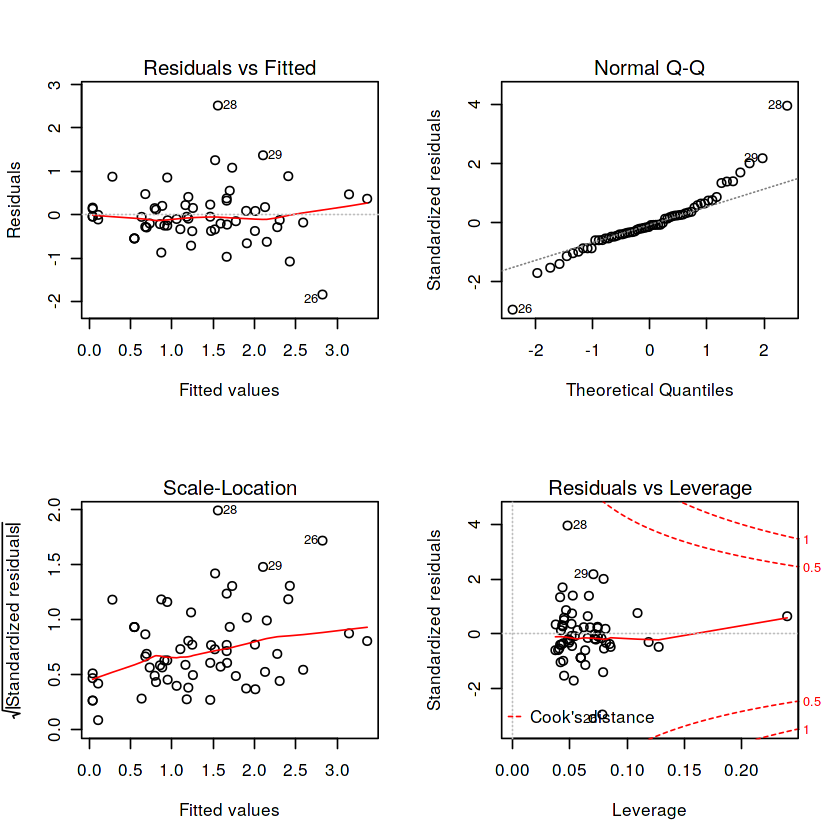

In [51]:
# Could also centre the average number of nests variable before doing the regression.
nest.ctr <- avg.no.nests-mean(avg.no.nests)
extinct.ctr.mlr <- lm(log.extinct~ nest.ctr+size+migratory)
summary(extinct.ctr.mlr)
par(mfrow=c(2,2))
plot(extinct.mlr)
par(mfrow=c(1,1))

**3. Use JAGS to fit a Bayesian multiple regression analysis.**

**3.1. Centre the *avg.no.nests* covariate. Also, use 3 sets of
 initial values for the parameters.**

See the `R` code below for the JAGS implementation.


In [82]:
# 3.1. Bayesian analysis
#We have computed the centered version of avg.no.nests in the solution to 2.1, and stored it in variable nest.ctr
extinct.model <-   
  "model {
# data that will be read in are n, log.extinct, nest.ctr, size.ind, mig.ind plus prior hyperparameters
# prior
beta0     ~ dnorm(mu.0,tau.0)
beta.nest ~ dnorm(mu.0,tau.0)
beta.size ~ dnorm(mu.0,tau.0)
beta.mig  ~ dnorm(mu.0,tau.0)
tau       ~ dgamma(tau.a,tau.b)

#Likelihood
for(i in 1:n) {
mu[i]  <- beta0+beta.nest*nest.ctr[i] + beta.size*size.ind[i] + beta.mig*mig.ind[i]
log.extinct[i] ~ dnorm(mu[i],tau)
}

sigma2 <- 1/tau

}"

extinct.data <- list(log.extinct=log.extinct,nest.ctr=nest.ctr,size.ind=size.ind,
                     mig.ind=mig.ind, n=n, mu.0=0, tau.0=1.0e-5, tau.a=0.01, tau.b=0.01)
#Specify three sets of intiial conditions
extinct.inits <- list(list(beta0=0.1,beta.nest=1, beta.size=10,beta.mig=3,tau=0.1),
                      list(beta0=0.2,beta.nest=-5,beta.size=5, beta.mig=1,tau=0.1),
                      list(beta0=0.2,beta.nest=10,beta.size=20,beta.mig=-2,tau=0.2))
num.chains <- 3
results.extinct.A<- jags.model(file=textConnection(extinct.model), 
                                  data=extinct.data , inits=extinct.inits , 
                                  n.chains=num.chains)
#Can also run without specifying initial values for the three chains.
#results.extinct.A<- jags.model(file=textConnection(extinct.model), 
#                                  data=extinct.data, 
#                                  n.chains=num.chains)
update(results.extinct.A, n.iter=1000)
results.extinct.B <- coda.samples(results.extinct.A, 
        variable.names=c("beta0","beta.nest", "beta.size","beta.mig","sigma2"), 
         n.iter=10000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 62
   Unobserved stochastic nodes: 5
   Total graph size: 358

Initializing model



**3.2. Plot the JAGS output to see the trace plots.**

Trace plots for the JAGS fit of this model to the data, after
centring the average number of nests, are shown below. These show that the chains are mixing well and the final posterior distributions look smooth and well sampled.


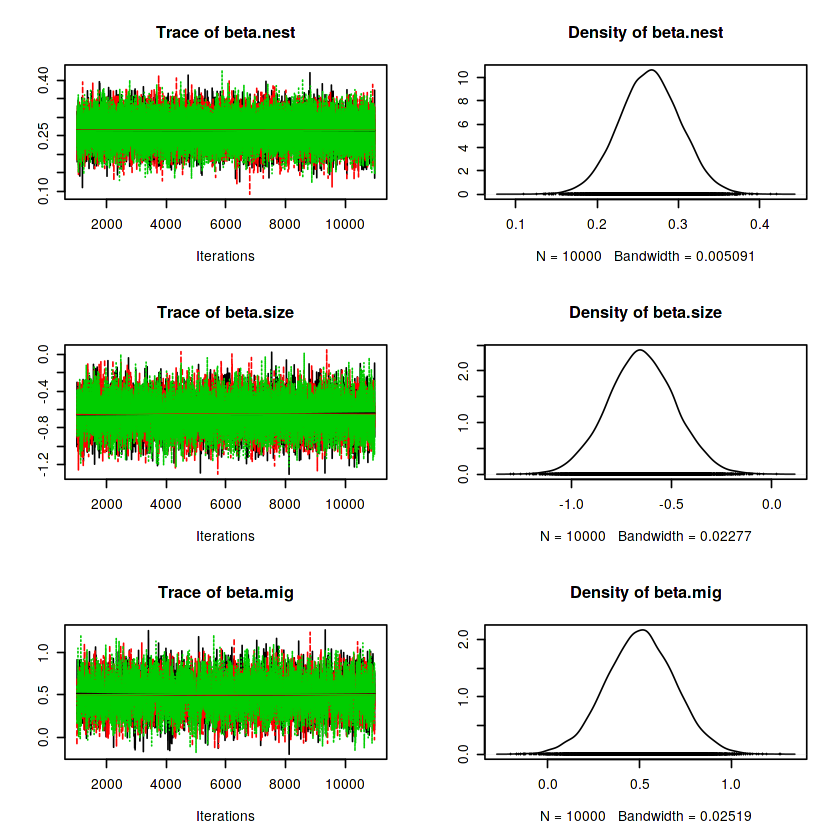

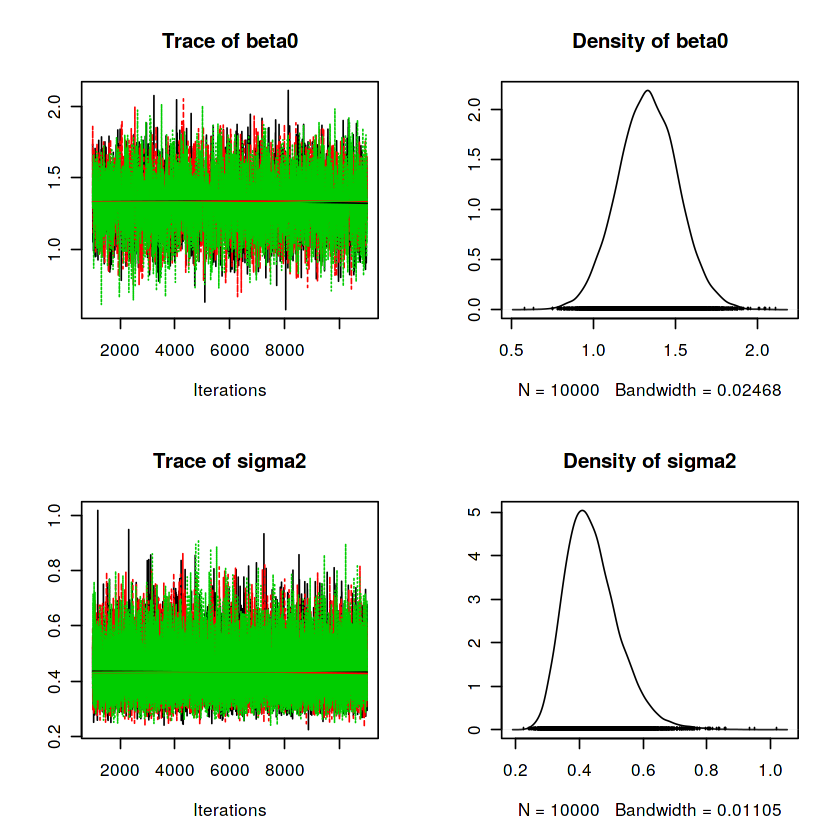

In [84]:
#Produce trace plots
par(mfrow=c(3,2))
plot(results.extinct.B[,c("beta.nest", "beta.size","beta.mig")])
par(mfrow=c(2,2))
plot(results.extinct.B[,c("beta0","sigma2")])
par(mfrow=c(1,1))


**3.3. Use the Gelman-Rubin diagnostics to check for convergence.**

Below we plot the Gelman-Rubin statistic based on the JAGS fit to the
model. The potential scale reduction factors are all equal to
$1$ and so we conclude that the results are robust.


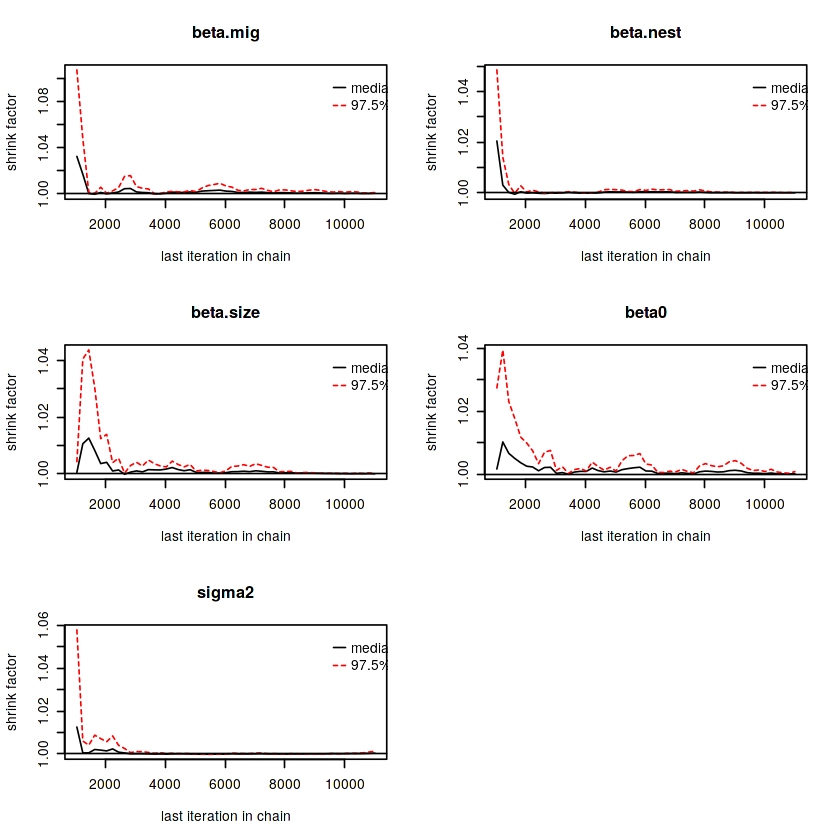

In [85]:
par(mfrow=c(3,2))
gelman.plot(results.extinct.B)

In [86]:
gelman.diag(results.extinct.B)

Potential scale reduction factors:

          Point est. Upper C.I.
beta.mig           1          1
beta.nest          1          1
beta.size          1          1
beta0              1          1
sigma2             1          1

Multivariate psrf

1

**3.4. Plot the autocorrelation functions.**

Below we show plots of the autocorrelation functions from the JAGS fit
to this model, showing very little autocorrelation.


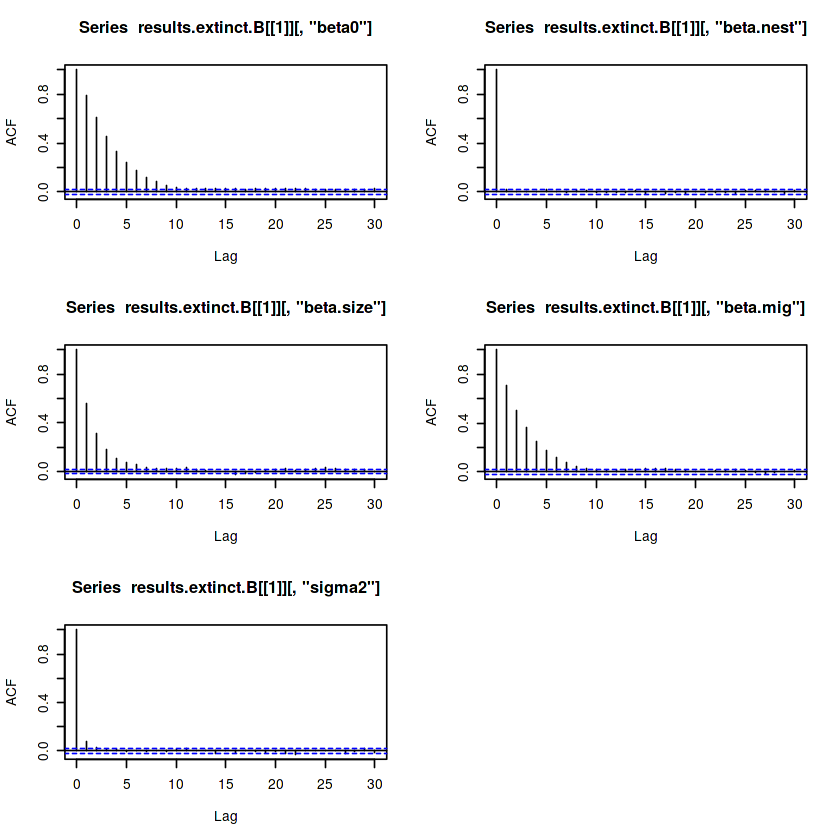

In [87]:
par(mfrow=c(3,2))
acf(results.extinct.B[[1]][,"beta0"],lag.max=30)
acf(results.extinct.B[[1]][,"beta.nest"],lag.max=30)
acf(results.extinct.B[[1]][,"beta.size"],lag.max=30)
acf(results.extinct.B[[1]][,"beta.mig"],lag.max=30)
acf(results.extinct.B[[1]][,"sigma2"],lag.max=30)
par(mfrow=c(1,1))

**3.5. Examine the effective sample sizes, and print out the summary statistics.**

 The effective sample sizes and summary statistics are computed below.

In [88]:
cat("ESS for beta0:",effectiveSize(results.extinct.B[[1]][,"beta0"]),"\n")     
cat("ESS for beta.nest:",effectiveSize(results.extinct.B[[1]][,"beta.nest"]),"\n") 
cat("ESS for beta.size:",effectiveSize(results.extinct.B[[1]][,"beta.size"]),"\n")
cat("ESS for beta.mig:",effectiveSize(results.extinct.B[[1]][,"beta.mig"]),"\n") 
cat("ESS for sigma2:",effectiveSize(results.extinct.B[[1]][,"sigma2"]),"\n") 

ESS for beta0: 1411.877 
ESS for beta.nest: 9634.474 
ESS for beta.size: 2843.464 
ESS for beta.mig: 1723.864 
ESS for sigma2: 8193.232 


In [89]:
#Get summary statistics for posterior distributions
summary(results.extinct.B) 


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

             Mean      SD  Naive SE Time-series SE
beta.mig   0.5054 0.18679 0.0010784      0.0026445
beta.nest  0.2648 0.03775 0.0002179      0.0002254
beta.size -0.6499 0.16967 0.0009796      0.0018161
beta0      1.3337 0.18303 0.0010567      0.0028722
sigma2     0.4411 0.08459 0.0004884      0.0005332

2. Quantiles for each variable:

             2.5%     25%     50%     75%   97.5%
beta.mig   0.1331  0.3801  0.5060  0.6308  0.8738
beta.nest  0.1909  0.2395  0.2649  0.2902  0.3388
beta.size -0.9829 -0.7629 -0.6508 -0.5367 -0.3150
beta0      0.9766  1.2109  1.3333  1.4577  1.6966
sigma2     0.3058  0.3806  0.4307  0.4904  0.6330


**3.6. Calculate studentised residuals, draw a QQ-plot to check
normality, plot posterior mean fitted values, and carry out
posterior predictive checks for the minimum and maximum
log.extinct times. (See the mtcars example in the R code for Lecture 1 on the Learn site for example code to do this.)**

First we compute the
studentised residuals. We
plot the posterior mean studentised residual for each
observation, versus the index numbering that observation. There
are no obvious outliers in this plot.

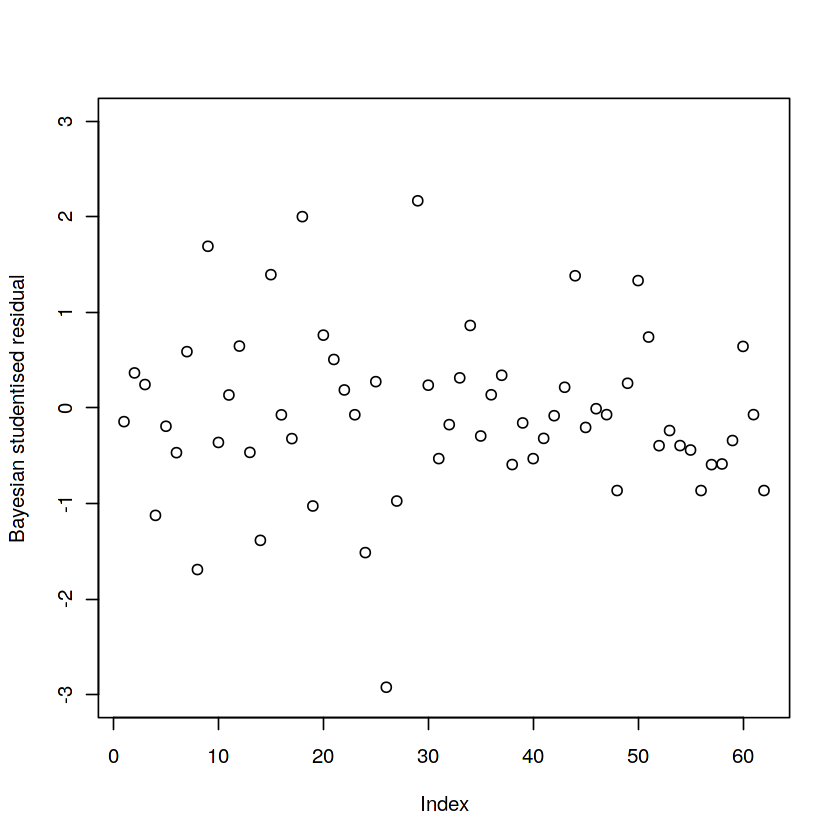

In [94]:
#Posterior predictive checks. 
#First compute studentised residuals fitted values
resmat=as.matrix(results.extinct.B)
niterf=nrow(resmat)
beta0=resmat[,4]; beta1=resmat[,2] ;beta2=resmat[,3]; beta3=resmat[,1]; sigma2=resmat[,5]
x=cbind(rep(1,n),nest.ctr,size.ind,mig.ind)
H=x%*%solve((t(x)%*%x))%*%t(x)
fittedvalues=matrix(0,nrow=n,ncol=niterf)
for(l in 1:niterf){
fittedvalues[,l]=beta0[l]*x[,1]+beta1[l]*x[,2]+beta2[l]*x[,3]+beta3[l]*x[,4]
}

#studentised residuals
studentisedresid=matrix(0,nrow=n,ncol=niterf)
for(l in 1:niterf){
 for(i in 1:n){
 studentisedresid[i,l]=(log.extinct[i]-fittedvalues[i,l])/(sqrt(sigma2[l]*(1-diag(H)[i])))
 }
}

#posterior mean of studentised residuals
studentisedresidm=numeric(n)
for(i in 1:n){
studentisedresidm[i]=mean(studentisedresid[i,])
}

#Plot of posterior mean studentised residual versus observation number.
par(mfrow=c(1,1))
plot(seq_along(studentisedresidm),studentisedresidm,xlab="Index",ylab="Bayesian studentised residual",ylim=c(-3,3))




In the figure below we show a q-q plot based on the posterior mean studentised
residuals. These lie reasonably well on the diagonal line.


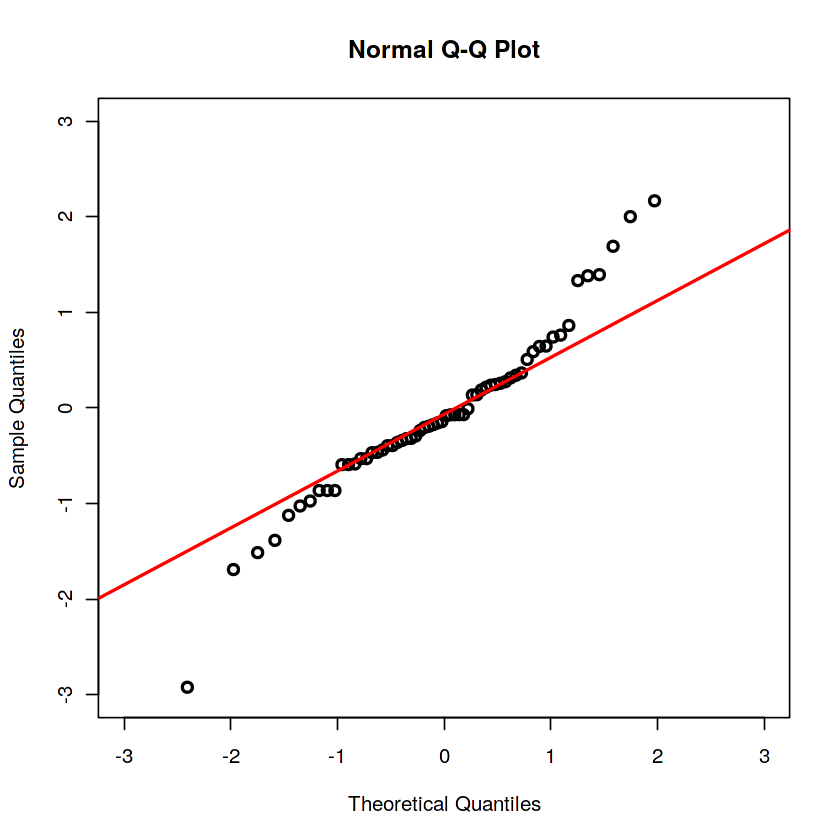

In [95]:

#QQ-plot
qqnorm(studentisedresidm,xlim=c(-3,3),ylim=c(-3,3),lwd=2)
qqline(studentisedresidm,col=2,lwd=2)


In the figure below we plot the studentised residual versus the posterior mean of
the fitted value of the model. In this figure we are looking for
any trends in the data which might suggest heteroscedastic
errors or missing terms in the model for the mean. There are no
obvious trends.


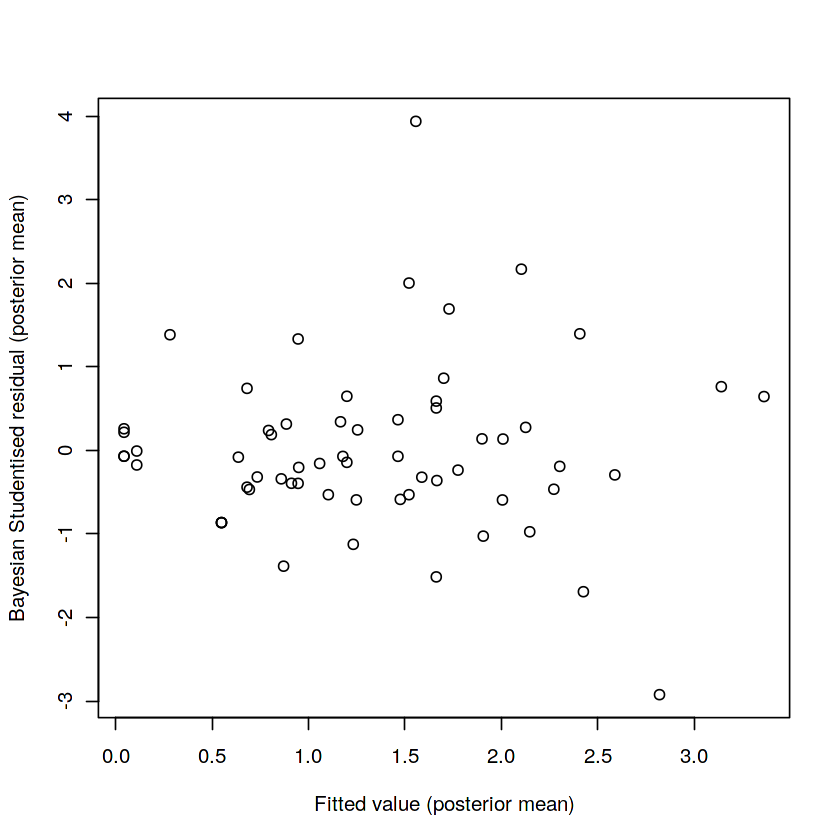

In [92]:
#Compute posterior mean fitted values
fittedvaluesm=numeric(n)
for(i in 1:n){
fittedvaluesm[i]=mean(fittedvalues[i,])
}

plot(fittedvaluesm,studentisedresidm,xlab="Fitted value (posterior mean)",ylab="Bayesian Studentised residual (posterior mean)")

Finally, the figures below show the posterior predictive
distribution of the minimum and maximum extinction time. These
are estimated by taking a sequence of random draws from the
posterior distribution, generating a new data set with
observations at the same set of covariate values as the original
data set based on the model for the mean specified by that draw
from the posterior and then computing the relevant statistic
from the mock data set. The histograms 
show the distribution of the derived statistic over those random
realisations. The observed value of the same statistic, i.e.
computed from the observed data set, is shown in both panels as
a vertical red line. If the model is a good description of the
data we expect the statistic value for the observed data set to
lie within the histogram of values, i.e., it should not be a
significant outlier. The distribution of the maximum extinction
time looks OK in that regard, but this is not the case for the
minimum extinction time. Looking more closely at the data set we
see that there are no extinction times recorded that are less
than 1 unit of time, but the linear model to log-extinction will
predict values that range between $0$ and $\infty$. This
suggests that the linear model is not a good description for
small extinction times, so modified versions of the model should
be explored.


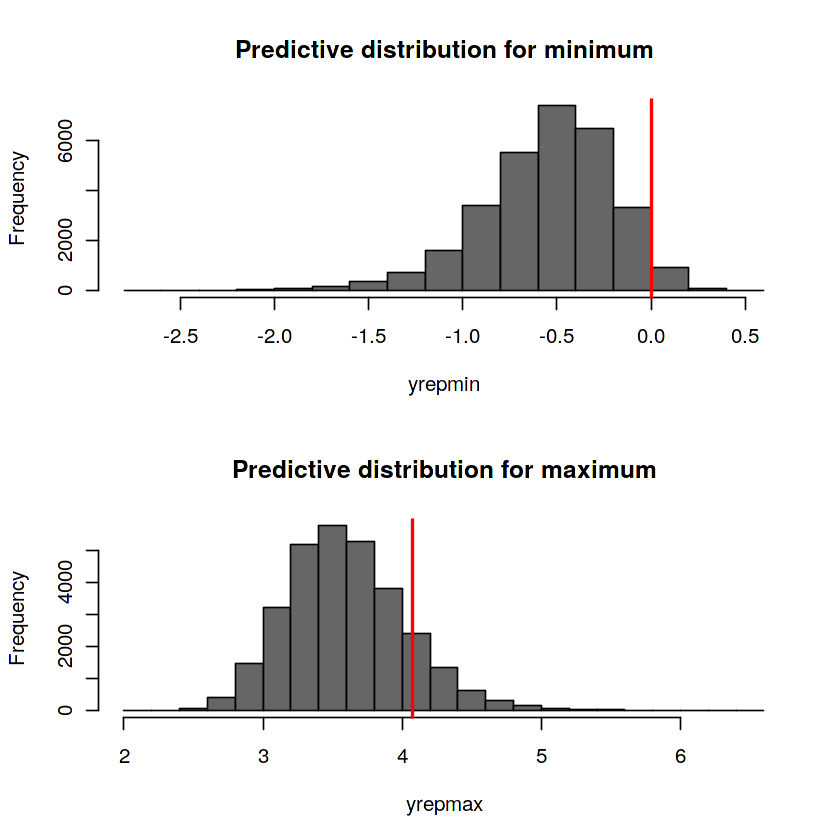

In [96]:
#Now do some predictive checks
#First replicate the data
yrep=matrix(0,nrow=n,ncol=niterf)
for(l in 1:niterf){
  for(i in 1:n){
    yrep[i,l]=rnorm(1,beta0[l]*x[i,1]+beta1[l]*x[i,2]+beta2[l]*x[i,3]+beta3[l]*x[i,4],sigma2[l])
  }
}

#Compute posterior preditive distribution of min amd max log(extinction time).
yrepmin=apply(yrep,2,min)
yrepmax=apply(yrep,2,max)

par(mfrow=c(2,1))
hist(yrepmin,col="gray40",main="Predictive distribution for minimum")
abline(v=min(log.extinct),col="red",lwd=2)
hist(yrepmax,col="gray40",main="Predictive distribution for maximum")
abline(v=max(log.extinct),col="red",lwd=2)

The histograms above show posterior predictive distribution for the minimum (top) and maximum (bottom) log extinction time for the Bayesian fit to the bird extinction time
data. The values int he observed data set are shown by vertical red lines. The lines seem to be within the typical range of the replicates, showing a reasonably good fit.

An alternative method would be to create the replicated directly with JAGS.
This can be done by adding a new stochastic node $\texttt{log.extinct.replicate[i]~ dnorm(mu[i],tau)}$ that has the same distribution as the observation $\texttt{log.extinct[i]}$ but it is not observed (i.e. not included in the data).

In [107]:
def.extinct.model.with.replicates <-   
  "model {
# data that will be read in are n, log.extinct, nest.ctr, size.ind, mig.ind plus prior hyperparameters
# prior
beta0     ~ dnorm(mu.0,tau.0)
beta.nest ~ dnorm(mu.0,tau.0)
beta.size ~ dnorm(mu.0,tau.0)
beta.mig  ~ dnorm(mu.0,tau.0)
tau       ~ dgamma(tau.a,tau.b)

#Likelihood
for(i in 1:n) {
mu[i]  <- beta0+beta.nest*nest.ctr[i] + beta.size*size.ind[i] + beta.mig*mig.ind[i]
log.extinct[i] ~ dnorm(mu[i],tau)
log.extinct.replicate[i]~ dnorm(mu[i],tau)
}

sigma2 <- 1/tau

}"

extinct.data <- list(log.extinct=log.extinct,nest.ctr=nest.ctr,size.ind=size.ind,
                     mig.ind=mig.ind, n=n, mu.0=0, tau.0=1.0e-5, tau.a=0.01, tau.b=0.01)
num.chains <- 3
model.extinct.with.replicates<- jags.model(file=textConnection(def.extinct.model.with.replicates), 
                                  data=extinct.data , 
                                  n.chains=num.chains)
#Can also run without specifying initial values for the three chains.
#results.extinct.A<- jags.model(file=textConnection(extinct.model), 
#                                  data=extinct.data, 
#                                  n.chains=num.chains)

update(model.extinct.with.replicates, n.iter=1000)
results.extinct.with.replicates <- coda.samples(model.extinct.with.replicates, 
    variable.names=c("log.extinct.replicate"),
         n.iter=10000)
#We only save the replicates, and not the other variables "beta0","beta.nest", "beta.size","beta.mig","sigma2"


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 62
   Unobserved stochastic nodes: 67
   Total graph size: 420

Initializing model



Now the replicates for each data point are contained in the MCMC output,
and they can be extracted to do the posterior predictive checks.

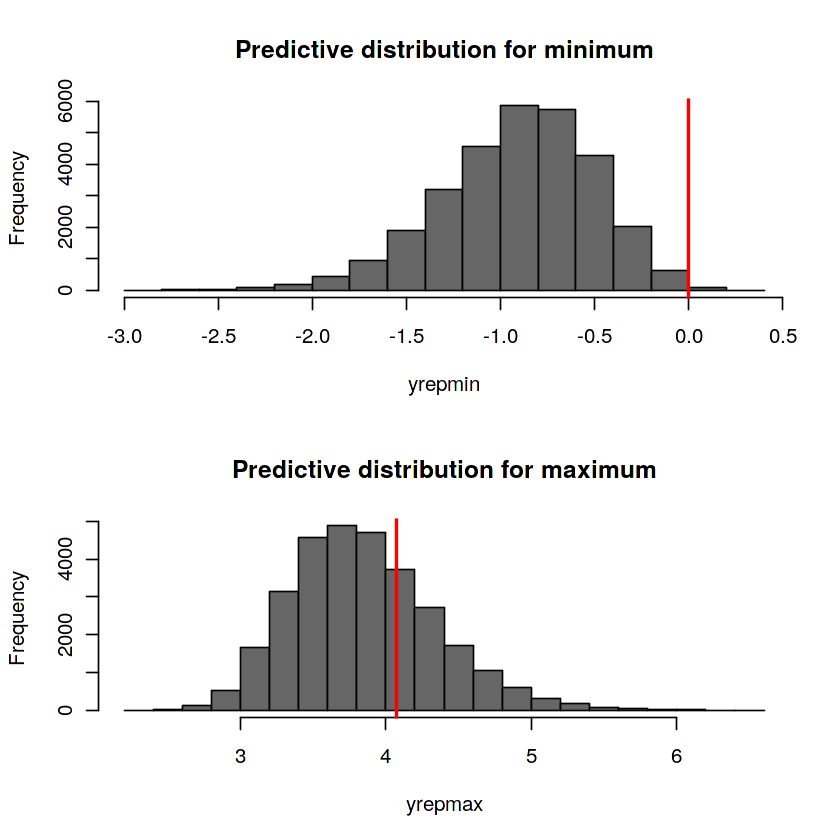

In [106]:
#Now do some predictive checks using the replicates from JAGS
#First, we convert the output into a matrix
matrix.results.extinct.with.replicates=as.matrix(results.extinct.with.replicates)

#The yrep matrix is easily obtained from this, 
#we need to use transpose t() due to the way we use yrep in the plots
yrep=t(matrix.results.extinct.with.replicates[1:niterf,1:n])

#Compute posterior preditive distribution of min amd max log(extinction time).
yrepmin=apply(yrep,2,min)
yrepmax=apply(yrep,2,max)

par(mfrow=c(2,1))
hist(yrepmin,col="gray40",main="Predictive distribution for minimum")
abline(v=min(log.extinct),col="red",lwd=2)
hist(yrepmax,col="gray40",main="Predictive distribution for maximum")
abline(v=max(log.extinct),col="red",lwd=2)

The results are the same as previously (up to some small difference due to randomness).